In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az
import xarray as xr
import corner

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

import jax
from jax import random
import jax.numpy as jnp

numpyro.set_host_device_count(4)

# Prepare the Data

## Load Clean Data

I have aggregated ice thickness observations for lakes and rivers in Alaska from 2000-2022. For subsequent observations on the same body of water during the same winter, I calculated the accumulated freezing degree days using the nearest weather station. Some basic data cleaning has been done to limit ourselves to less noisy observations.

In [2]:
ice_data = pd.read_csv("data/alaska_ice_thickness.csv")
ice_data = ice_data.sort_values("water_type")
ice_data

,id,name,latitude,longitude,elevation,date,thickness,date_lag,thickness_lag,ice_growth,AFDD,pct_nan,distance,station_id,water_type
0,ABRA2,Amber Lake North,62.1925,-150.503,449.0,2007-03-02,99.06,2007-02-01,68.58,30.48,311.666667,0.000000,25.615184,PATK,lake
815,LMHA2,Lake Minchumina,63.9097,-152.279,740.0,2003-02-28,86.36,2003-02-04,73.66,12.70,271.527778,0.280000,3.416640,PAMH,lake
814,LMHA2,Lake Minchumina,63.9097,-152.279,740.0,2003-02-04,73.66,2003-01-01,66.04,7.62,623.055556,0.285714,3.416640,PAMH,lake
813,LMHA2,Lake Minchumina,63.9097,-152.279,740.0,2003-01-01,66.04,2002-11-30,45.72,20.32,446.944444,0.333333,3.416640,PAMH,lake
812,LHIA2,Lake Hood Ice near Anchorage,61.1775,-149.949,71.0,2022-02-28,55.88,2022-02-01,50.80,5.08,96.111111,0.000000,1.151426,PALH,lake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,CHFA2,Chena River at Fairbanks,64.8458,-147.701,428.0,2012-12-31,68.58,2012-11-29,35.56,33.02,913.055556,0.000000,9.537879,PAFA,river
326,CHFA2,Chena River at Fairbanks,64.8458,-147.701,428.0,2012-03-29,55.88,2012-03-01,48.26,7.62,463.888889,0.000000,9.537879,PAFA,river
325,CHFA2,Chena River at Fairbanks,64.8458,-147.701,428.0,2012-03-01,48.26,2012-02-01,60.96,-12.70,440.555556,0.000000,9.537879,PAFA,river
332,CHFA2,Chena River at Fairbanks,64.8458,-147.701,428.0,2014-03-03,38.10,2014-01-03,30.48,7.62,990.555556,0.000000,9.537879,PAFA,river


## Define the Response Variable

First we need to transform the raw ice thickness data into our response variable as defined in Stefan's equation.

In [3]:
ice_data["delta_h2"] = ice_data["thickness"]**2 - ice_data["thickness_lag"]**2

## Define Predictor Variables

To help implement our Bayesian models, we are going to recode two of the variables as factors. In general, this is a much more popular choice in Bayesian methods compared to one-hot encoding because it makes defining priors more intuitive even though the resulting models are mathematically equivalent.

In [4]:
# factorize water_type
water_type_idx, water_type_map = pd.factorize(ice_data["water_type"])
ice_data["water_type_idx"] = water_type_idx
water_type_map

Index(['lake', 'river'], dtype='object')

In [5]:
# factorize id
site_idx, site_map = pd.factorize(ice_data["id"])
ice_data["site_idx"] = site_idx
site_map

Index(['ABRA2', 'LMHA2', 'LHIA2', 'NICA2', 'OLNA2', 'JWLA2', 'KZBA2', 'GOOA2',
       'TALA2', 'WPAA2', 'SMLA2', 'WSTA2', 'QULA2', 'CNPA2', 'ALSA2', 'CHYA2',
       'CCVA2', 'CTLA2', 'TFIA2', 'BTTA2', 'BETA2', 'TAFA2', 'ENNA2', 'SXRA2',
       'SNOA2', 'YEAA2', 'WULA2', 'TRCA2', 'TRTA2', 'CHAA2', 'CNDA2', 'CPIA2',
       'MCGA2', 'GRSA2', 'GYRA2', 'EYRA2', 'CSRA2', 'CHFA2', 'SLWA2', 'MONA2',
       'CHLA2', 'NINA2', 'YPSA2'],
      dtype='object')

# Exploratory Data Analysis

Before jumping into the models, let's quickly visualize the data.

## Overall Trend

First, plot the response variable against AFDD for all the data.

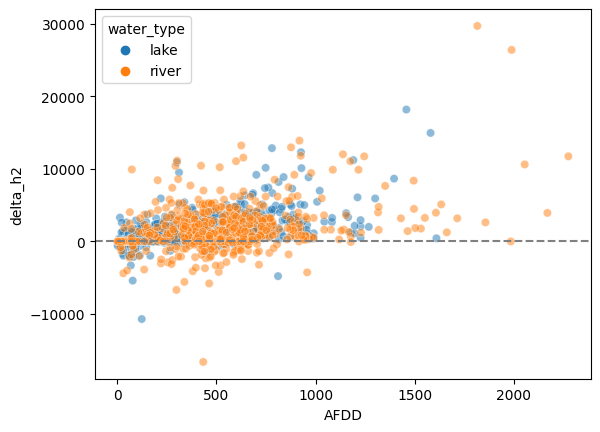

In [6]:
sns.scatterplot(
    ice_data,
    x="AFDD",
    y="delta_h2",
    hue="water_type",
    alpha=0.5
)
plt.axhline(
    y=0,
    linestyle="dashed",
    color="gray"
)
plt.show()

A few observations we can make.

First, there does seem to be a positive linear trend between the response and AFDD, but there is a lot of unexplained variance. So we should expect large uncertainties, especially in prediction intervals.

Secondly, the variances for lakes and rivers look to be significantly different. The rivers seem to have much more of a spread from the central tendency.

Third, we see a lot of extreme observations away from the center of the data. That should prompt us to consider robust regression methods.

## Individual Trends

The previous plot shows the overall trend, but let's look at each body of water individually as well. We expect that there will be unobserved environmental effects that uniquely impact each body of water.

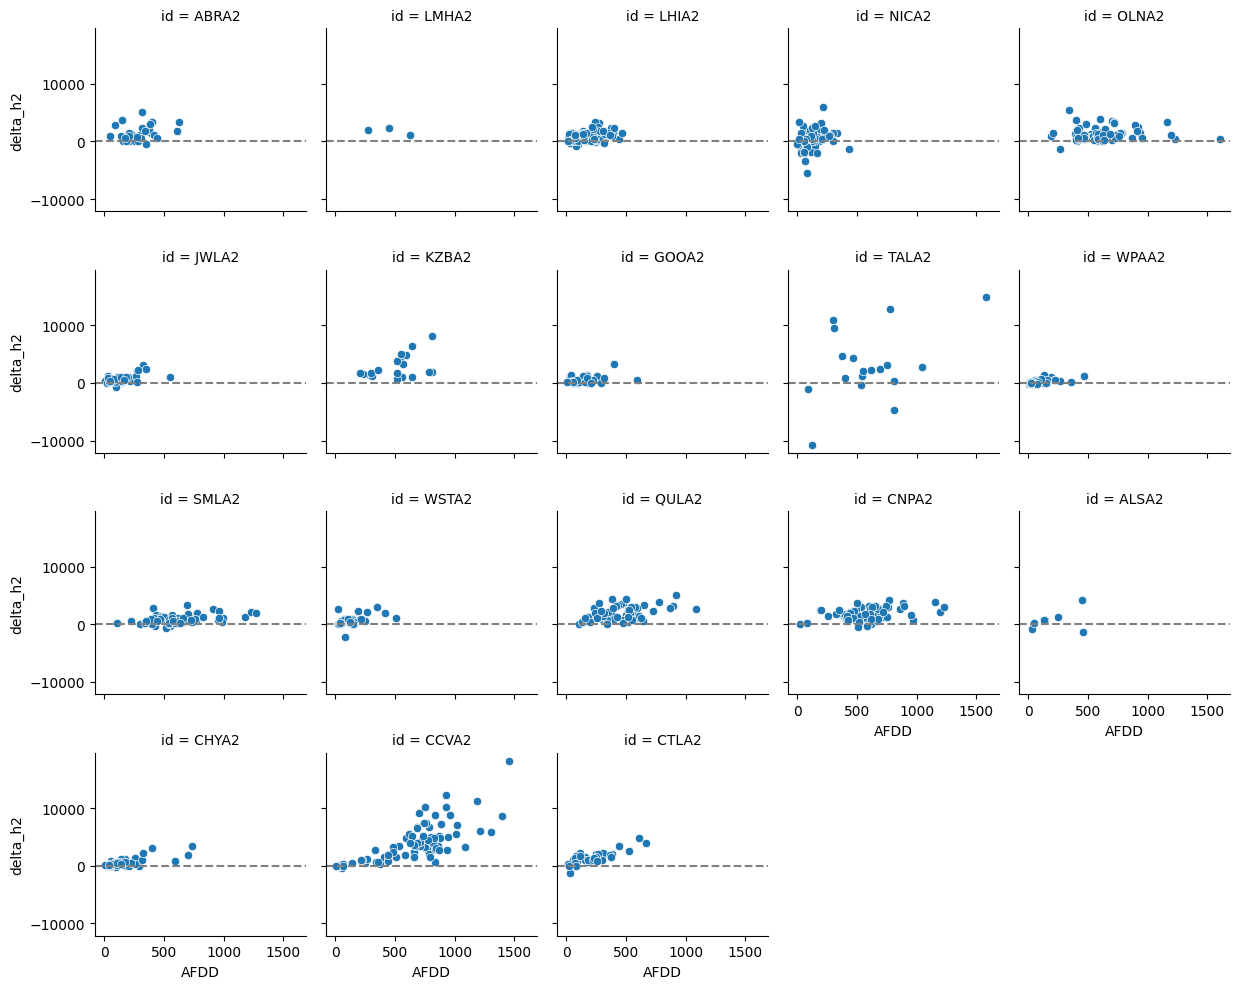

In [7]:
g_lake = sns.FacetGrid(
    ice_data[ice_data["water_type"] == "lake"],
    col="id",
    height=2.5,
    col_wrap=5
)
g_lake.map_dataframe(sns.scatterplot, x="AFDD", y="delta_h2")
g_lake.refline(y=0)
plt.show()

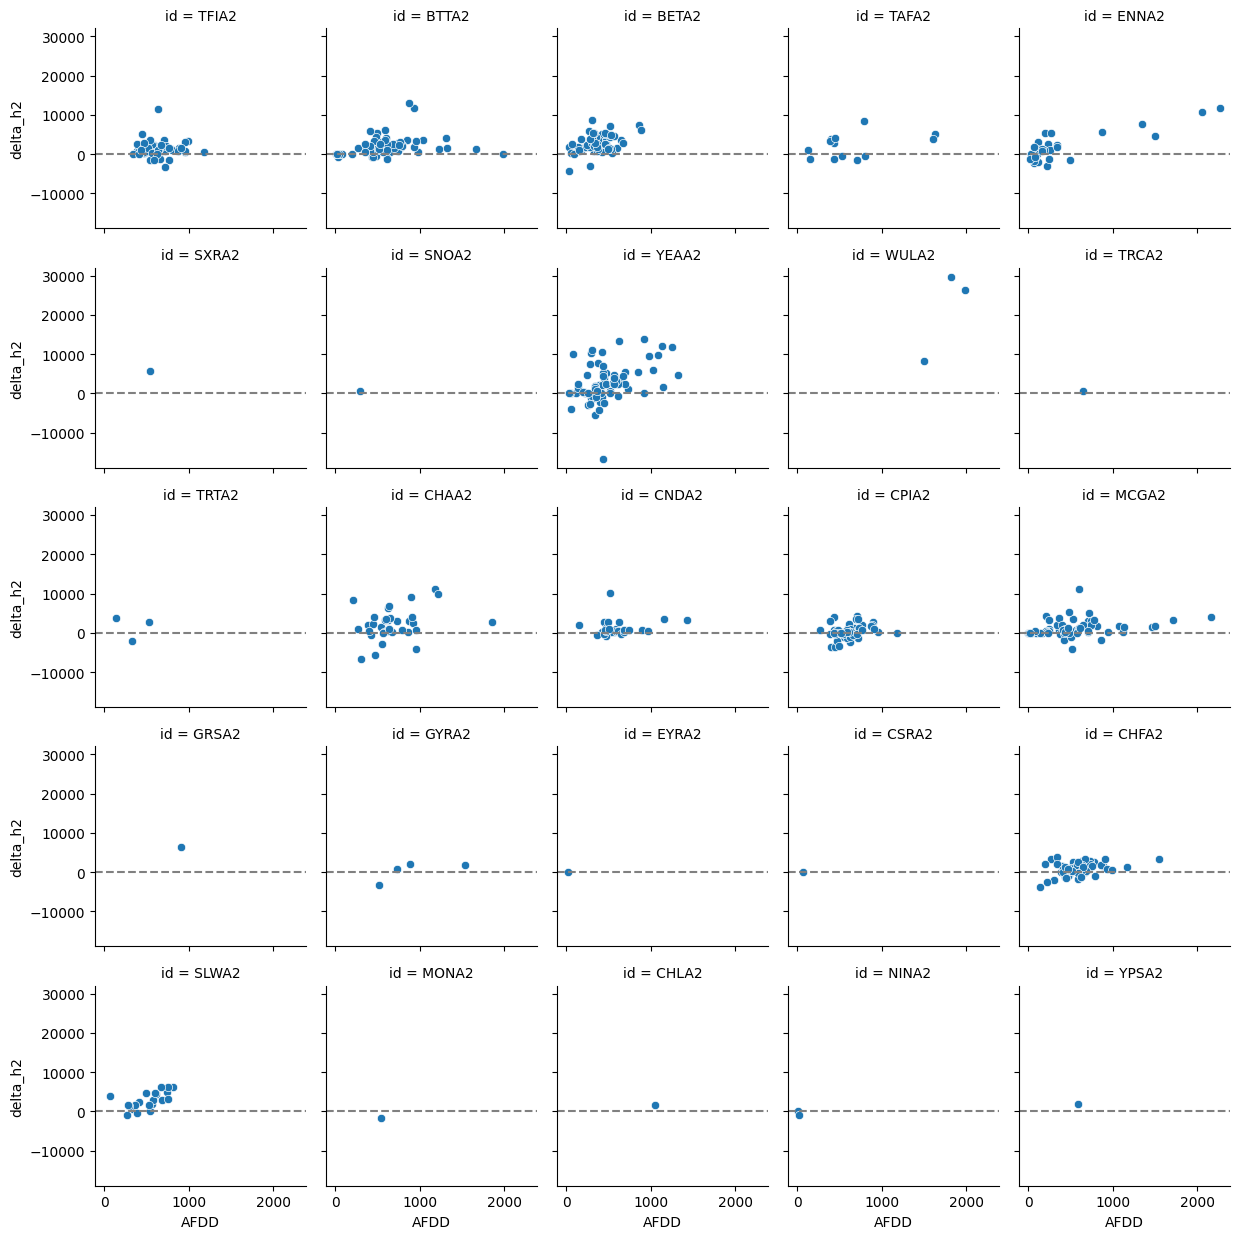

In [8]:
g_river = sns.FacetGrid(
    ice_data[ice_data["water_type"] == "river"],
    col="id",
    height=2.5,
    col_wrap=5
)
g_river.map_dataframe(sns.scatterplot, x="AFDD", y="delta_h2")
g_river.refline(y=0)
plt.show()

# Bayesian Regression

Now that the data is prepared, we will run and compare a few different Bayesian regression models. We will start simple and slowly add more information to the model and measure the improvement.

## Fully Pooled (Baseline)

The first model is going to be the most basic with just one parameter, $\beta$. This would be the average relationship between AFDD and our response variable for all lakes and rivers in the data. We will use EM 1110-2-1612 Table 2-2 as our reference for priors.

<img src="img/alpha_coefficients.png" alt="alpha" width="600"/>

### Define Priors

The first step is to define our priors. There are a few categories of priors:

- Informative
- Weakly Informative
- Uninformative

In this model we are going to leverage a mix of these. We will use an informative prior on the slope parameter and a weakly informative prior on the standard deviation parameter.

In this case with plenty of data (evidence), the exact choices in prior are not as important because they will mostly be overwhelmed by the data as long as they are reasonable. However, they are a good method to impose our scientific knowledge on the model.

Let's first define the prior distribution on the slope parameter. We will rely on the Army Corps of Engineers Ice Engineering manual to help generate this distribution.

Our model's slope is the square of the reported $\alpha$ values so let's print the squared coefficients for reference.

In [9]:
print(f"Beta range: average = {1.7**2:.2f}, min = {0.7**2:.2f}, max = {2.7**2:.2f}")

Beta range: average = 2.89, min = 0.49, max = 7.29


We also know scientifically, that the coefficient cannot be negative. That would mean that water would freeze when temperatures are above freezing and melt when they are below freezing. A common distribution for constraining parameters to be positive is the gamma distribution. So let's find a gamma distribution that captures our prior information.

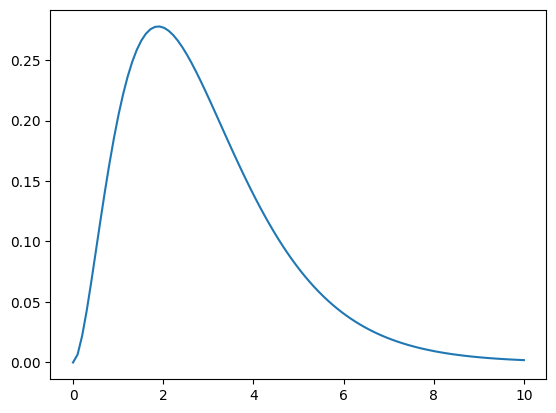

Mean: 2.89
Probability contained between 0.49 and 7.29: 0.96


In [10]:
x = np.linspace(0, 10, 100)
rate = 1
concentration = 2.89 * rate
rv_gamma = stats.gamma(concentration, scale=1/rate)
plt.plot(x, rv_gamma.pdf(x))
plt.show()
print(f"Mean: {rv_gamma.mean():.2f}")
print(f"Probability contained between 0.49 and 7.29: {rv_gamma.cdf(7.29) - rv_gamma.cdf(0.49):.2f}")

The gamma distribution isn't the only reasonable prior to use for the slope. A log-normal also seems reasonable, and given the right model a normally distributed prior might also give good results. Try a few other distributions and see how well they do.

[Log-Normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)

[Normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

The prior on sigma will be less interesting. We just want it to be greater than zero and have a long tail. It is common to use an exponential distribution for this type of parameter. Based on the range of the data, we expect a fairly large sigma term so set $\lambda = 0.01$ which would give a mean of 100.

### Normal Model

Start with a linear model using the normal distribution for the likelihood. This is very similar to OLS regression, especially if you are familiar with the MLE formulation. In fact, the MAP of this model would be identical to OLS if we were to use a completely uninformative (flat) prior.

This is what our model looks like in statistical notation.

$$
\begin{align*}
    H &\sim \mathcal{N}(\mu, \sigma) \\
    \mu &\sim \beta \ \text{AFDD} \\
    \beta &\sim \text{Gamma}(2.89, 1) \\
    \sigma &\sim \text{Exponential}(0.01)
\end{align*}
$$

#### Prior Predictive Simulation

It is always good practice to check the prior predictive distribution of the model before training it.

In [11]:
def baseline_normal(AFDD, delta_h2=None):
    beta = numpyro.sample("beta", dist.Gamma(concentration, rate))

    mu = numpyro.deterministic("mu", beta * AFDD)
    sigma = numpyro.sample("sigma", dist.Exponential(0.01))
    
    with numpyro.plate("data", len(AFDD)):
        return numpyro.sample("delta_h2", dist.Normal(mu, sigma), obs=delta_h2)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


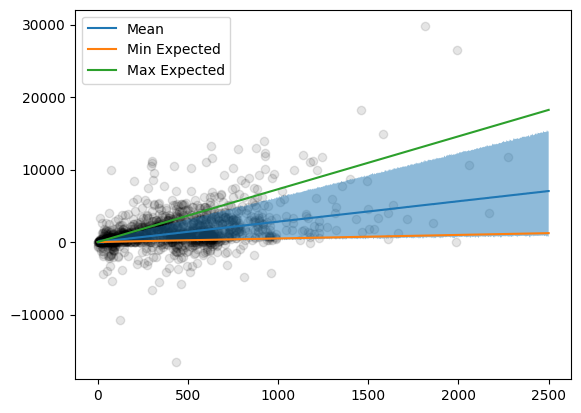

In [12]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

afdd = np.linspace(0, 2500, 1000)
prior_predictive = Predictive(baseline_normal, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, AFDD=afdd)["delta_h2"]

mean_prior_pred = prior_predictions.mean(axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.95)

# plot data and prior predictions
plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, mean_prior_pred, label="Mean")
plt.fill_between(afdd, hpdi_prior_pred[0], hpdi_prior_pred[1], alpha=0.5)
# plot guide lines of literature values
plt.plot(afdd, afdd*0.49, label="Min Expected")
plt.plot(afdd, afdd*7.29, label="Max Expected")
plt.legend()
plt.show()

The prior information looks accurate to what we would expect from the literature, and it gives us confidence that we correctly specified the model.

#### Fit the Model

Now we fit the model using Markov chain Monte Carlo with No U-turn Sampling (NUTS). We won't go into detail on the software implementation of how we actually sample the posterior distribution.

In [13]:
rng_key, rng_key_ = random.split(rng_key)

mcmc_baseline_normal = MCMC(
    NUTS(baseline_normal),
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True
)

mcmc_baseline_normal.run(
    rng_key_,
    AFDD = ice_data["AFDD"].values,
    delta_h2 = ice_data["delta_h2"].values
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
mcmc_baseline_normal.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      3.52      0.11      3.52      3.35      3.71   3691.83      1.00
     sigma   2318.58     43.47   2317.59   2244.62   2386.75   4081.14      1.00

Number of divergences: 0


#### Posterior Predictive Simulation

Finally we can sample from the posterior distribution and plot the results.

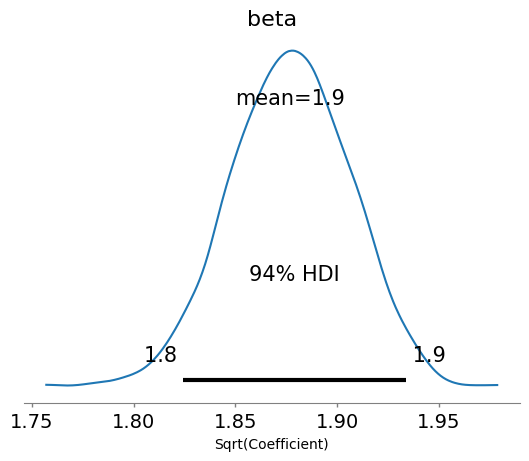

In [15]:
# simulate posterior samples
rng_key, rng_key_ = random.split(rng_key)

samples_baseline_normal = mcmc_baseline_normal.get_samples()
result_baseline_normal = az.from_numpyro(mcmc_baseline_normal)
az.plot_posterior(result_baseline_normal, var_names=["beta"], transform = np.sqrt)
plt.xlabel("Sqrt(Coefficient)")
plt.show()

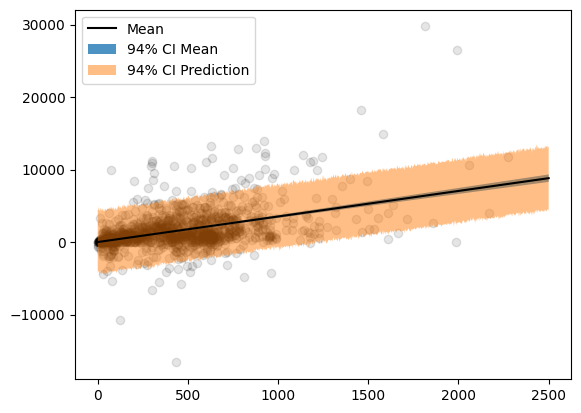

In [16]:
rng_key, rng_key_ = random.split(rng_key)

samples_baseline_normal = mcmc_baseline_normal.get_samples()
post_predictive = Predictive(baseline_normal, samples_baseline_normal)
post_predictions = post_predictive(rng_key_, AFDD=afdd)["delta_h2"]
hpdi_post_pred = hpdi(post_predictions, 0.94)

post_mu = jnp.expand_dims(samples_baseline_normal["beta"], -1)*afdd
hpdi_post_mu = hpdi(post_mu, 0.94)

plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, post_mu.mean(axis=0), color="black", label="Mean")
plt.fill_between(afdd, hpdi_post_mu[0], hpdi_post_mu[1], alpha=0.8, label="94% CI Mean")
plt.fill_between(afdd, hpdi_post_pred[0], hpdi_post_pred[1], alpha=0.5, label="94% CI Prediction")
plt.legend()
plt.show()

### Robust Model

From the previous result, it is obvious that the model is not putting enough posterior probability into the tails around the mean. To address this, we will use a Student T distribution rather than a normal distribution. There is some debate about what prior to use on the Student T's degree of freedom parameter, but we will use the Juarez-Steel prior. 

For a more in-depth discussion and debate, see https://statmodeling.stat.columbia.edu/2015/05/17/do-we-have-any-recommendations-for-priors-for-student_ts-degrees-of-freedom-parameter/.

The updated statistical notation is the following:

$$
\begin{align*}
    H &\sim \text{StudentT}(\nu, \mu, \sigma) \\
    \mu &\sim \beta \ \text{AFDD} \\
    \nu &\sim \text{Gamma}(2, 0.1) \\
    \beta &\sim \text{Gamma}(2.89, 1) \\
    \sigma &\sim \text{Exponential}(0.01)
\end{align*}
$$

#### Prior Predictive Simulation

In [17]:
def baseline_T(AFDD, delta_h2=None):
    beta = numpyro.sample("beta", dist.Gamma(concentration, rate))

    mu = numpyro.deterministic("mu", beta * AFDD)
    sigma = numpyro.sample("sigma", dist.Exponential(0.01))
    nu = numpyro.sample("nu", dist.Gamma(2, 0.1))  # Juarez-Steel prior
    
    with numpyro.plate("data", len(AFDD)):
        return numpyro.sample("delta_h2", dist.StudentT(nu, mu, sigma), obs=delta_h2)

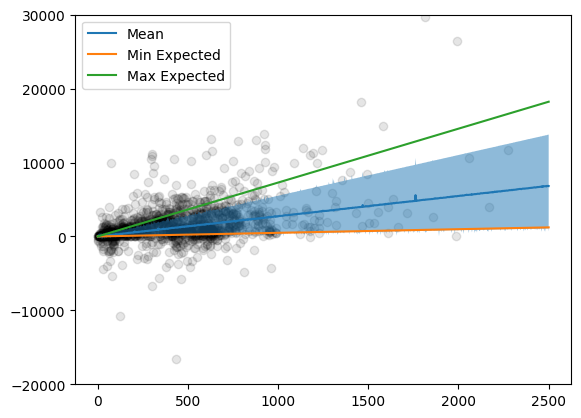

In [18]:
rng_key, rng_key_ = random.split(rng_key)

afdd = np.linspace(0, 2500, 1000)
prior_predictive = Predictive(baseline_T, num_samples=100)
prior_predictions = prior_predictive(rng_key_, AFDD=afdd)["delta_h2"]

mean_prior_pred = prior_predictions.mean(axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.94)

# plot data and prior predictions
plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, mean_prior_pred, label="Mean")
plt.fill_between(afdd, hpdi_prior_pred[0], hpdi_prior_pred[1], alpha=0.5)
# plot guide lines of literature values
plt.plot(afdd, afdd*0.49, label="Min Expected")
plt.plot(afdd, afdd*7.29, label="Max Expected")
plt.ylim(-20e3, 30e3)
plt.legend()
plt.show()

#### Fit the Model

In [19]:
rng_key, rng_key_ = random.split(rng_key)

mcmc_baseline_T = MCMC(
    NUTS(baseline_T),
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True
)

mcmc_baseline_T.run(
    rng_key_,
    AFDD = ice_data["AFDD"].values,
    delta_h2 = ice_data["delta_h2"].values
)
mcmc_baseline_T.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.48      0.08      2.48      2.35      2.63   2451.00      1.00
        nu      1.78      0.12      1.78      1.58      1.98   1964.06      1.00
     sigma    960.46     41.74    960.02    894.60   1031.04   2000.83      1.00

Number of divergences: 0


#### Posterior Predictive Simulation

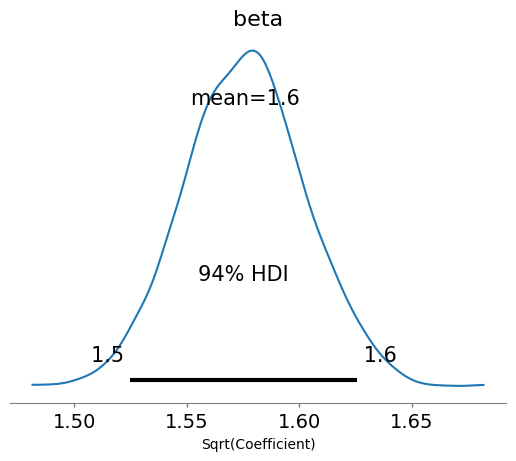

In [20]:
result_baseline_T = az.from_numpyro(mcmc_baseline_T)
az.plot_posterior(result_baseline_T, var_names=["beta"], transform = np.sqrt)
plt.xlabel("Sqrt(Coefficient)")
plt.show()

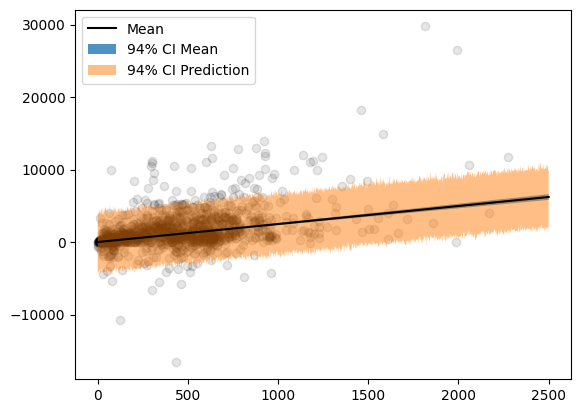

In [21]:
rng_key, rng_key_ = random.split(rng_key)

samples_baseline_T = mcmc_baseline_T.get_samples()
post_predictive = Predictive(baseline_T, samples_baseline_T)
post_predictions = post_predictive(rng_key_, AFDD=afdd)["delta_h2"]
hpdi_post_pred = hpdi(post_predictions, 0.94)

post_mu = jnp.expand_dims(samples_baseline_T["beta"], -1)*afdd
hpdi_post_mu = hpdi(post_mu, 0.94)

plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, post_mu.mean(axis=0), color="black", label="Mean")
plt.fill_between(afdd, hpdi_post_mu[0], hpdi_post_mu[1], alpha=0.8, label="94% CI Mean")
plt.fill_between(afdd, hpdi_post_pred[0], hpdi_post_pred[1], alpha=0.5, label="94% CI Prediction")
plt.legend()
plt.show()

The robust model significantly pulled down the estimate of the slope. Going forward we will use this as our baseline for better models.

## Pooled with Water Type Fixed Effects

We have prior knowledge that rivers and lakes have different alpha coefficients, where on average rivers freeze slower than lakes. Let's incorporate this effect into the model.

### Define Priors

In [22]:
print(f"River range: average = {1.5**2:.2f}, min = {0.7**2:.2f}, max = {1.7**2:.2f}")
print(f"Lake range: average = {2**2:.2f}, min = {1.7**2:.2f}, max = {2.7**2:.2f}")

River range: average = 2.25, min = 0.49, max = 2.89
Lake range: average = 4.00, min = 2.89, max = 7.29


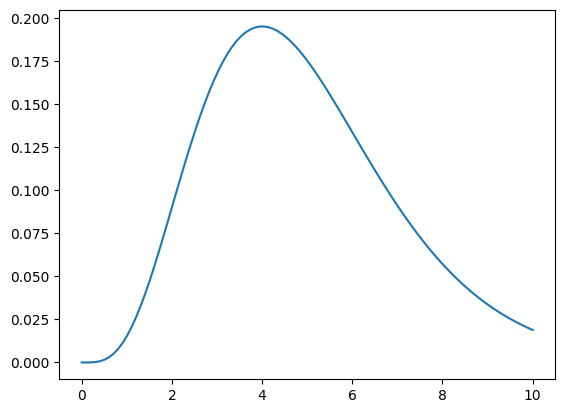

Mean: 5.00
Probability contained between 2.89 and 7.29: 0.69


In [23]:
x = np.linspace(0, 10, 100)
rate_lake = 1
concentration_lake = 5 * rate
rv_gamma_lake = stats.gamma(concentration_lake, scale=1/rate_lake)
plt.plot(x, rv_gamma_lake.pdf(x))
plt.show()
print(f"Mean: {rv_gamma_lake.mean():.2f}")
print(f"Probability contained between 2.89 and 7.29: {rv_gamma_lake.cdf(7.29) - rv_gamma_lake.cdf(2.89):.2f}")

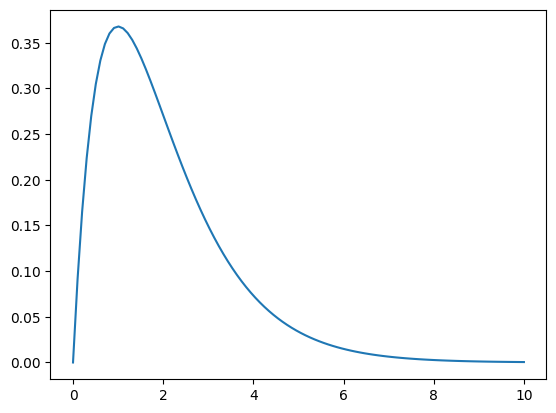

Mean: 2.00
Probability contained between 0.49 and 2.89: 0.70


In [24]:
x = np.linspace(0, 10, 100)
rate_river = 1
concentration_river = 2 * rate
rv_gamma_river = stats.gamma(concentration_river, scale=1/rate_river)
plt.plot(x, rv_gamma_river.pdf(x))
plt.show()
print(f"Mean: {rv_gamma_river.mean():.2f}")
print(f"Probability contained between 0.49 and 2.89: {rv_gamma_river.cdf(2.89) - rv_gamma_river.cdf(0.49):.2f}")

### Homoskedastic Model

Let's start by assuming that the variance is the same for both rivers and lakes.

$$
\begin{align*}
    H &\sim \text{StudentT}(\nu, \mu, \sigma) \\
    \mu_i &\sim \beta_i \ \text{AFDD} \\
    \nu &\sim \text{Gamma}(2, 0.1) \\
    \beta_\text{lake} &\sim \text{Gamma}(2.89, 1) \\
    \beta_\text{river} &\sim \text{Gamma}(2, 1) \\
    \sigma &\sim \text{Exponential}(0.01)
\end{align*}
$$

#### Prior Predictive Simulation

In [25]:
def fully_pooled(water_type, AFDD, delta_h2=None):
    beta = jnp.array([
        numpyro.sample("beta_lake", dist.Gamma(concentration_lake, rate_lake)),    # lakes
        numpyro.sample("beta_river", dist.Gamma(concentration_river, rate_river))  # rivers
    ])

    mu = numpyro.deterministic("mu", beta[water_type] * AFDD)
    sigma = numpyro.sample("sigma", dist.Exponential(0.01))
    nu = numpyro.sample("nu", dist.Gamma(2, 0.1))  # Juarez-Steel prior
    
    with numpyro.plate("data", len(AFDD)):
        return numpyro.sample("delta_h2", dist.StudentT(nu, mu, sigma), obs=delta_h2)

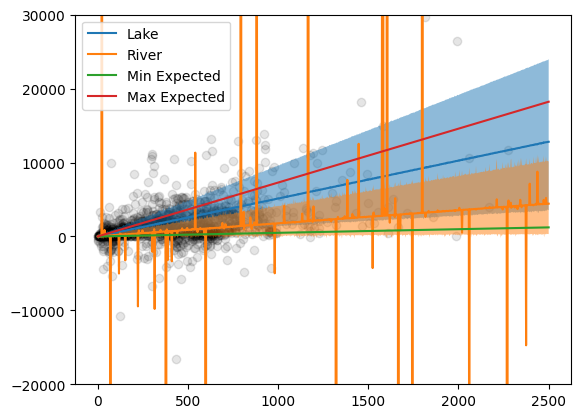

In [26]:
rng_key, rng_key_ = random.split(rng_key)

afdd = np.linspace(0, 2500, 1000)
prior_predictive = Predictive(fully_pooled, num_samples=100)
prior_predictions_lake = prior_predictive(rng_key_, water_type=0, AFDD=afdd)["delta_h2"]

rng_key, rng_key_ = random.split(rng_key)
prior_predictions_river = prior_predictive(rng_key_, water_type=1, AFDD=afdd)["delta_h2"]

mean_prior_pred_lake = prior_predictions_lake.mean(axis=0)
hpdi_prior_pred_lake = hpdi(prior_predictions_lake, 0.94)

mean_prior_pred_river = prior_predictions_river.mean(axis=0)
hpdi_prior_pred_river = hpdi(prior_predictions_river, 0.94)

# plot data and prior predictions
plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, mean_prior_pred_lake, label="Lake")
plt.fill_between(afdd, hpdi_prior_pred_lake[0], hpdi_prior_pred_lake[1], alpha=0.5)
plt.plot(afdd, mean_prior_pred_river, label="River")
plt.fill_between(afdd, hpdi_prior_pred_river[0], hpdi_prior_pred_river[1], alpha=0.5)
# plot guide lines of literature values
plt.plot(afdd, afdd*0.49, label="Min Expected")
plt.plot(afdd, afdd*7.29, label="Max Expected")
plt.ylim(-20000, 30000)
plt.legend()
plt.show()

#### Fit the Model

In [27]:
rng_key, rng_key_ = random.split(rng_key)

mcmc_fully_pooled = MCMC(
    NUTS(fully_pooled),
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
)

mcmc_fully_pooled.run(
    rng_key_,
    water_type=ice_data["water_type_idx"].values,
    AFDD=ice_data["AFDD"].values,
    delta_h2=ice_data["delta_h2"].values
)
mcmc_fully_pooled.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_lake      2.89      0.11      2.89      2.72      3.08   3242.49      1.00
  beta_river      1.97      0.11      1.97      1.78      2.16   3498.09      1.00
          nu      1.74      0.12      1.73      1.54      1.93   2752.37      1.00
       sigma    934.82     40.65    932.90    868.65   1002.66   2748.56      1.00

Number of divergences: 0


#### Posterior Predictive Simulation

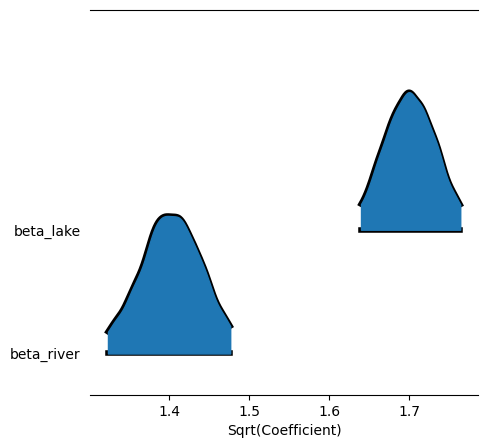

In [28]:
result_fully_pooled = az.from_numpyro(mcmc_fully_pooled)
az.plot_forest(
    result_fully_pooled,
    kind="ridgeplot",
    var_names=["beta_lake", "beta_river"],
    transform=np.sqrt,
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(5, 5),
)
plt.xlabel("Sqrt(Coefficient)")
plt.show()

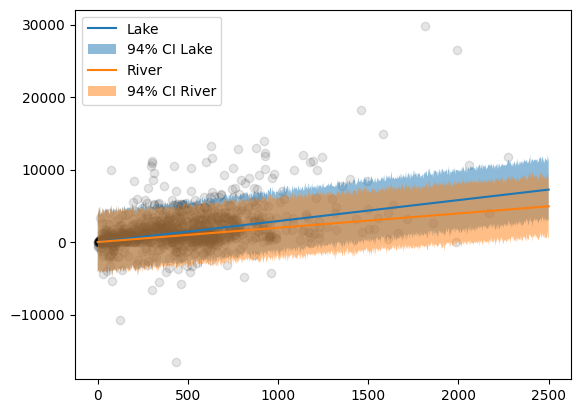

In [29]:
rng_key, rng_key_ = random.split(rng_key)

samples_fully_pooled = mcmc_fully_pooled.get_samples()
post_predictive = Predictive(fully_pooled, samples_fully_pooled)

post_predictions = {}
post_mu = {}
hpdi_post_pred = {}

# lake posterior predictions
post_predictions["lake"] = post_predictive(rng_key_, water_type=0, AFDD=afdd)["delta_h2"]
post_mu["lake"] = jnp.expand_dims(samples_fully_pooled["beta_lake"], -1)*afdd
hpdi_post_pred["lake"] = hpdi(post_predictions["lake"], 0.94)

# river posterior predictions
post_predictions["river"] = post_predictive(rng_key_, water_type=1, AFDD=afdd)["delta_h2"]
post_mu["river"] = jnp.expand_dims(samples_fully_pooled["beta_river"], -1)*afdd
hpdi_post_pred["river"] = hpdi(post_predictions["river"], 0.94)

plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, post_mu["lake"].mean(axis=0), color="tab:blue", label="Lake")
plt.fill_between(afdd, hpdi_post_pred["lake"][0], hpdi_post_pred["lake"][1], alpha=0.5, label="94% CI Lake")
plt.plot(afdd, post_mu["river"].mean(axis=0), color="tab:orange", label="River")
plt.fill_between(afdd, hpdi_post_pred["river"][0], hpdi_post_pred["river"][1], alpha=0.5, label="94% CI River")
plt.legend()
plt.show()

/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


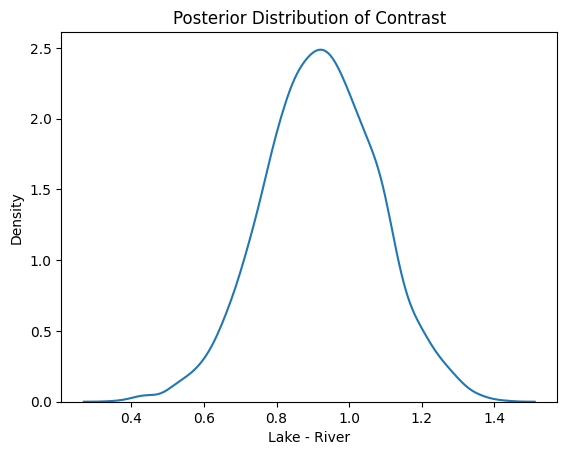

In [30]:
samples_fully_pooled = az.extract(mcmc_fully_pooled)
contrast = samples_fully_pooled.beta_lake.values - samples_fully_pooled.beta_river.values
sns.kdeplot(contrast)
plt.xlabel("Lake - River")
plt.title("Posterior Distribution of Contrast")
plt.show()

### Heteroskedastic Model

Now let's let the variance in the residuals change depending on the water type.

$$
\begin{align*}
    H &\sim \text{StudentT}(\nu, \mu, \sigma) \\
    \mu_i &\sim \beta_i \ \text{AFDD} \\
    \nu &\sim \text{Gamma}(2, 0.1) \\
    \beta_\text{lake} &\sim \text{Gamma}(2.89, 1) \\
    \beta_\text{river} &\sim \text{Gamma}(2, 1) \\
    \sigma_i &\sim \text{Exponential}(0.01)
\end{align*}
$$

#### Prior Predictive Simulation

In [31]:
def fully_pooled_hs(water_type, AFDD, delta_h2=None):
    beta = jnp.array([
        numpyro.sample("beta_lake", dist.Gamma(concentration_lake, rate_lake)),    # lakes
        numpyro.sample("beta_river", dist.Gamma(concentration_river, rate_river))  # rivers
    ])
    
    s = jnp.array([
        numpyro.sample("sigma_lake", dist.Exponential(0.01)),
        numpyro.sample("sigma_river", dist.Exponential(0.01))
    ])

    mu = numpyro.deterministic("mu", beta[water_type] * AFDD)
    sigma = s[water_type]
    nu = numpyro.sample("nu", dist.Gamma(2, 0.1))
    
    
    with numpyro.plate("data", len(AFDD)):
        return numpyro.sample("delta_h2", dist.StudentT(nu, mu, sigma), obs=delta_h2)

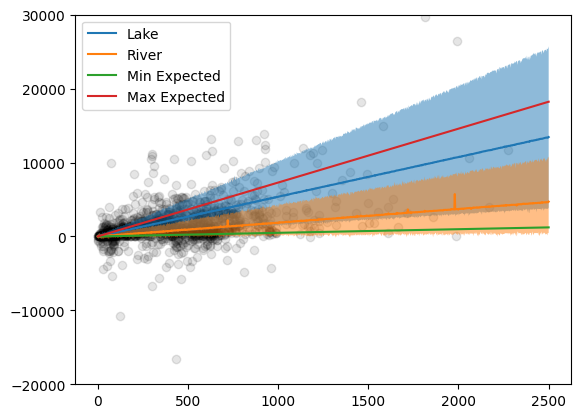

In [32]:
rng_key, rng_key_ = random.split(rng_key)

afdd = np.linspace(0, 2500, 1000)
prior_predictive = Predictive(fully_pooled_hs, num_samples=100)
prior_predictions_lake = prior_predictive(rng_key_, water_type=0, AFDD=afdd)["delta_h2"]

rng_key, rng_key_ = random.split(rng_key)
prior_predictions_river = prior_predictive(rng_key_, water_type=1, AFDD=afdd)["delta_h2"]

mean_prior_pred_lake = prior_predictions_lake.mean(axis=0)
hpdi_prior_pred_lake = hpdi(prior_predictions_lake, 0.94)

mean_prior_pred_river = prior_predictions_river.mean(axis=0)
hpdi_prior_pred_river = hpdi(prior_predictions_river, 0.94)

# plot data and prior predictions
plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, mean_prior_pred_lake, label="Lake")
plt.fill_between(afdd, hpdi_prior_pred_lake[0], hpdi_prior_pred_lake[1], alpha=0.5)
plt.plot(afdd, mean_prior_pred_river, label="River")
plt.fill_between(afdd, hpdi_prior_pred_river[0], hpdi_prior_pred_river[1], alpha=0.5)
# plot guide lines of literature values
plt.plot(afdd, afdd*0.49, label="Min Expected")
plt.plot(afdd, afdd*7.29, label="Max Expected")
plt.ylim(-20000, 30000)
plt.legend()
plt.show()

#### Fit the Model

In [33]:
rng_key, rng_key_ = random.split(rng_key)

mcmc_fully_pooled_hs = MCMC(
    NUTS(fully_pooled_hs),
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
)

mcmc_fully_pooled_hs.run(
    rng_key_,
    water_type=ice_data["water_type_idx"].values,
    AFDD=ice_data["AFDD"].values,
    delta_h2=ice_data["delta_h2"].values
)
mcmc_fully_pooled_hs.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_lake      2.83      0.11      2.83      2.67      3.01   4331.28      1.00
   beta_river      2.18      0.14      2.18      1.95      2.39   4250.59      1.00
           nu      1.98      0.14      1.97      1.74      2.21   2778.49      1.00
   sigma_lake    712.64     34.85    712.16    655.26    769.09   3372.75      1.00
  sigma_river   1472.49     78.09   1471.12   1350.74   1607.95   3494.02      1.00

Number of divergences: 0


#### Posterior Predictive Simulation

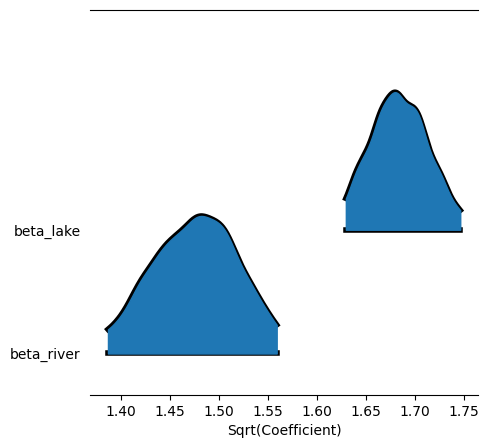

In [34]:
result_fully_pooled_hs = az.from_numpyro(mcmc_fully_pooled_hs)
az.plot_forest(
    result_fully_pooled_hs,
    kind="ridgeplot",
    var_names=["beta_lake", "beta_river"],
    transform=np.sqrt,
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(5, 5),
)
plt.xlabel("Sqrt(Coefficient)")
plt.show()

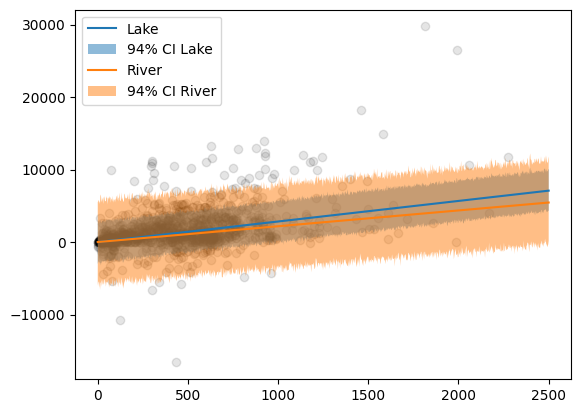

In [35]:
rng_key, rng_key_ = random.split(rng_key)

samples_fully_pooled_hs = mcmc_fully_pooled_hs.get_samples()
post_predictive = Predictive(fully_pooled_hs, samples_fully_pooled_hs)

post_predictions = {}
post_mu = {}
hpdi_post_pred = {}

# lake posterior predictions
post_predictions["lake"] = post_predictive(rng_key_, water_type=0, AFDD=afdd)["delta_h2"]
post_mu["lake"] = jnp.expand_dims(samples_fully_pooled_hs["beta_lake"], -1)*afdd
hpdi_post_pred["lake"] = hpdi(post_predictions["lake"], 0.94)

# river posterior predictions
post_predictions["river"] = post_predictive(rng_key_, water_type=1, AFDD=afdd)["delta_h2"]
post_mu["river"] = jnp.expand_dims(samples_fully_pooled_hs["beta_river"], -1)*afdd
hpdi_post_pred["river"] = hpdi(post_predictions["river"], 0.94)

plt.scatter(ice_data["AFDD"], ice_data["delta_h2"], color="black", alpha=0.1)
plt.plot(afdd, post_mu["lake"].mean(axis=0), color="tab:blue", label="Lake")
plt.fill_between(afdd, hpdi_post_pred["lake"][0], hpdi_post_pred["lake"][1], alpha=0.5, label="94% CI Lake")
plt.plot(afdd, post_mu["river"].mean(axis=0), color="tab:orange", label="River")
plt.fill_between(afdd, hpdi_post_pred["river"][0], hpdi_post_pred["river"][1], alpha=0.5, label="94% CI River")
plt.legend()
plt.show()

/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


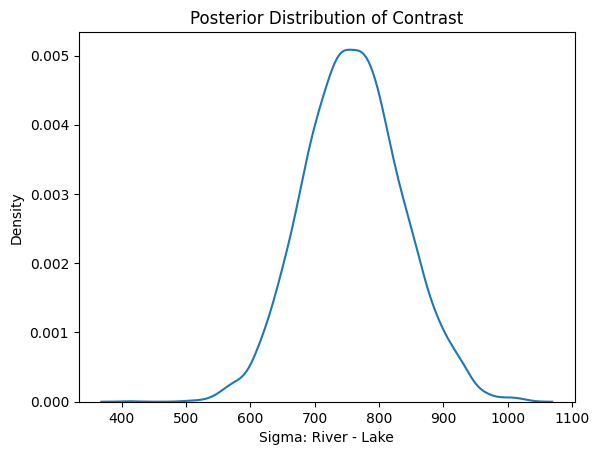

In [36]:
samples_fully_pooled_hs = az.extract(mcmc_fully_pooled_hs)
contrast = samples_fully_pooled_hs.sigma_river.values - samples_fully_pooled_hs.sigma_lake.values
sns.kdeplot(contrast)
plt.xlabel("Sigma: River - Lake")
plt.title("Posterior Distribution of Contrast")
plt.show()

The model finds a substantial difference in the variance of residuals between lakes and rivers. But does it actually help make better predictions?

### Compare Models

To assess how well our models would perform on unseen data for prediction, we use WAIC (https://en.wikipedia.org/wiki/Watanabe%E2%80%93Akaike_information_criterion).

In [37]:
az.compare(
    {
        "Baseline": result_baseline_T,
        "Fully Pooled": result_fully_pooled,
        "Fully Pooled Heteroskedastic": result_fully_pooled_hs
    },
    ic="waic"
)

/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Fully Pooled Heteroskedastic,0,-12810.947296,6.993359,0.000000,9.505569e-01,48.657148,0.00000,False,log
Fully Pooled,1,-12882.413817,5.942633,71.466521,4.944308e-02,49.022048,12.51697,False,log
Baseline,2,-12896.712202,4.109779,85.764906,9.594547e-13,48.468558,12.45088,False,log


Pooling with water type fixed effects improves predictive performance over the baseline model, and the heteroskedastic model is a substantial improvement.

## Unpooled

As we saw in the EDA, each individual body of water has a potentially different slope. One way to account for that is to fit a separate slope to each one (fixed-effect).

$$
\begin{align*}
    H &\sim \text{StudentT}(\nu, \mu, \sigma) \\
    \mu_j &\sim \beta_j \ \text{AFDD} \\
    \nu &\sim \text{Gamma}(2, 0.1) \\
    \beta_j &\sim \text{Gamma}(2.89, 1) \\
    \sigma &\sim \text{Exponential}(0.01)
\end{align*}
$$

### Prior Predictive Simulation

In [38]:
def unpooled(site_id, AFDD, delta_h2=None):
    n_sites = np.unique(site_id).shape[0]
    
    with numpyro.plate("site", n_sites):
        beta = numpyro.sample("beta", dist.Gamma(concentration, rate))

    n_obs = site_id.shape[0]
    
    mu = numpyro.deterministic("mu", beta[site_id] * AFDD)
    sigma = numpyro.sample("sigma", dist.Exponential(0.01))
    nu = numpyro.sample("nu", dist.Gamma(2, 0.1))  # Juarez-Steel prior
    
    with numpyro.plate("data", n_obs):
        return numpyro.sample("delta_h2", dist.StudentT(nu, mu, sigma), obs=delta_h2)

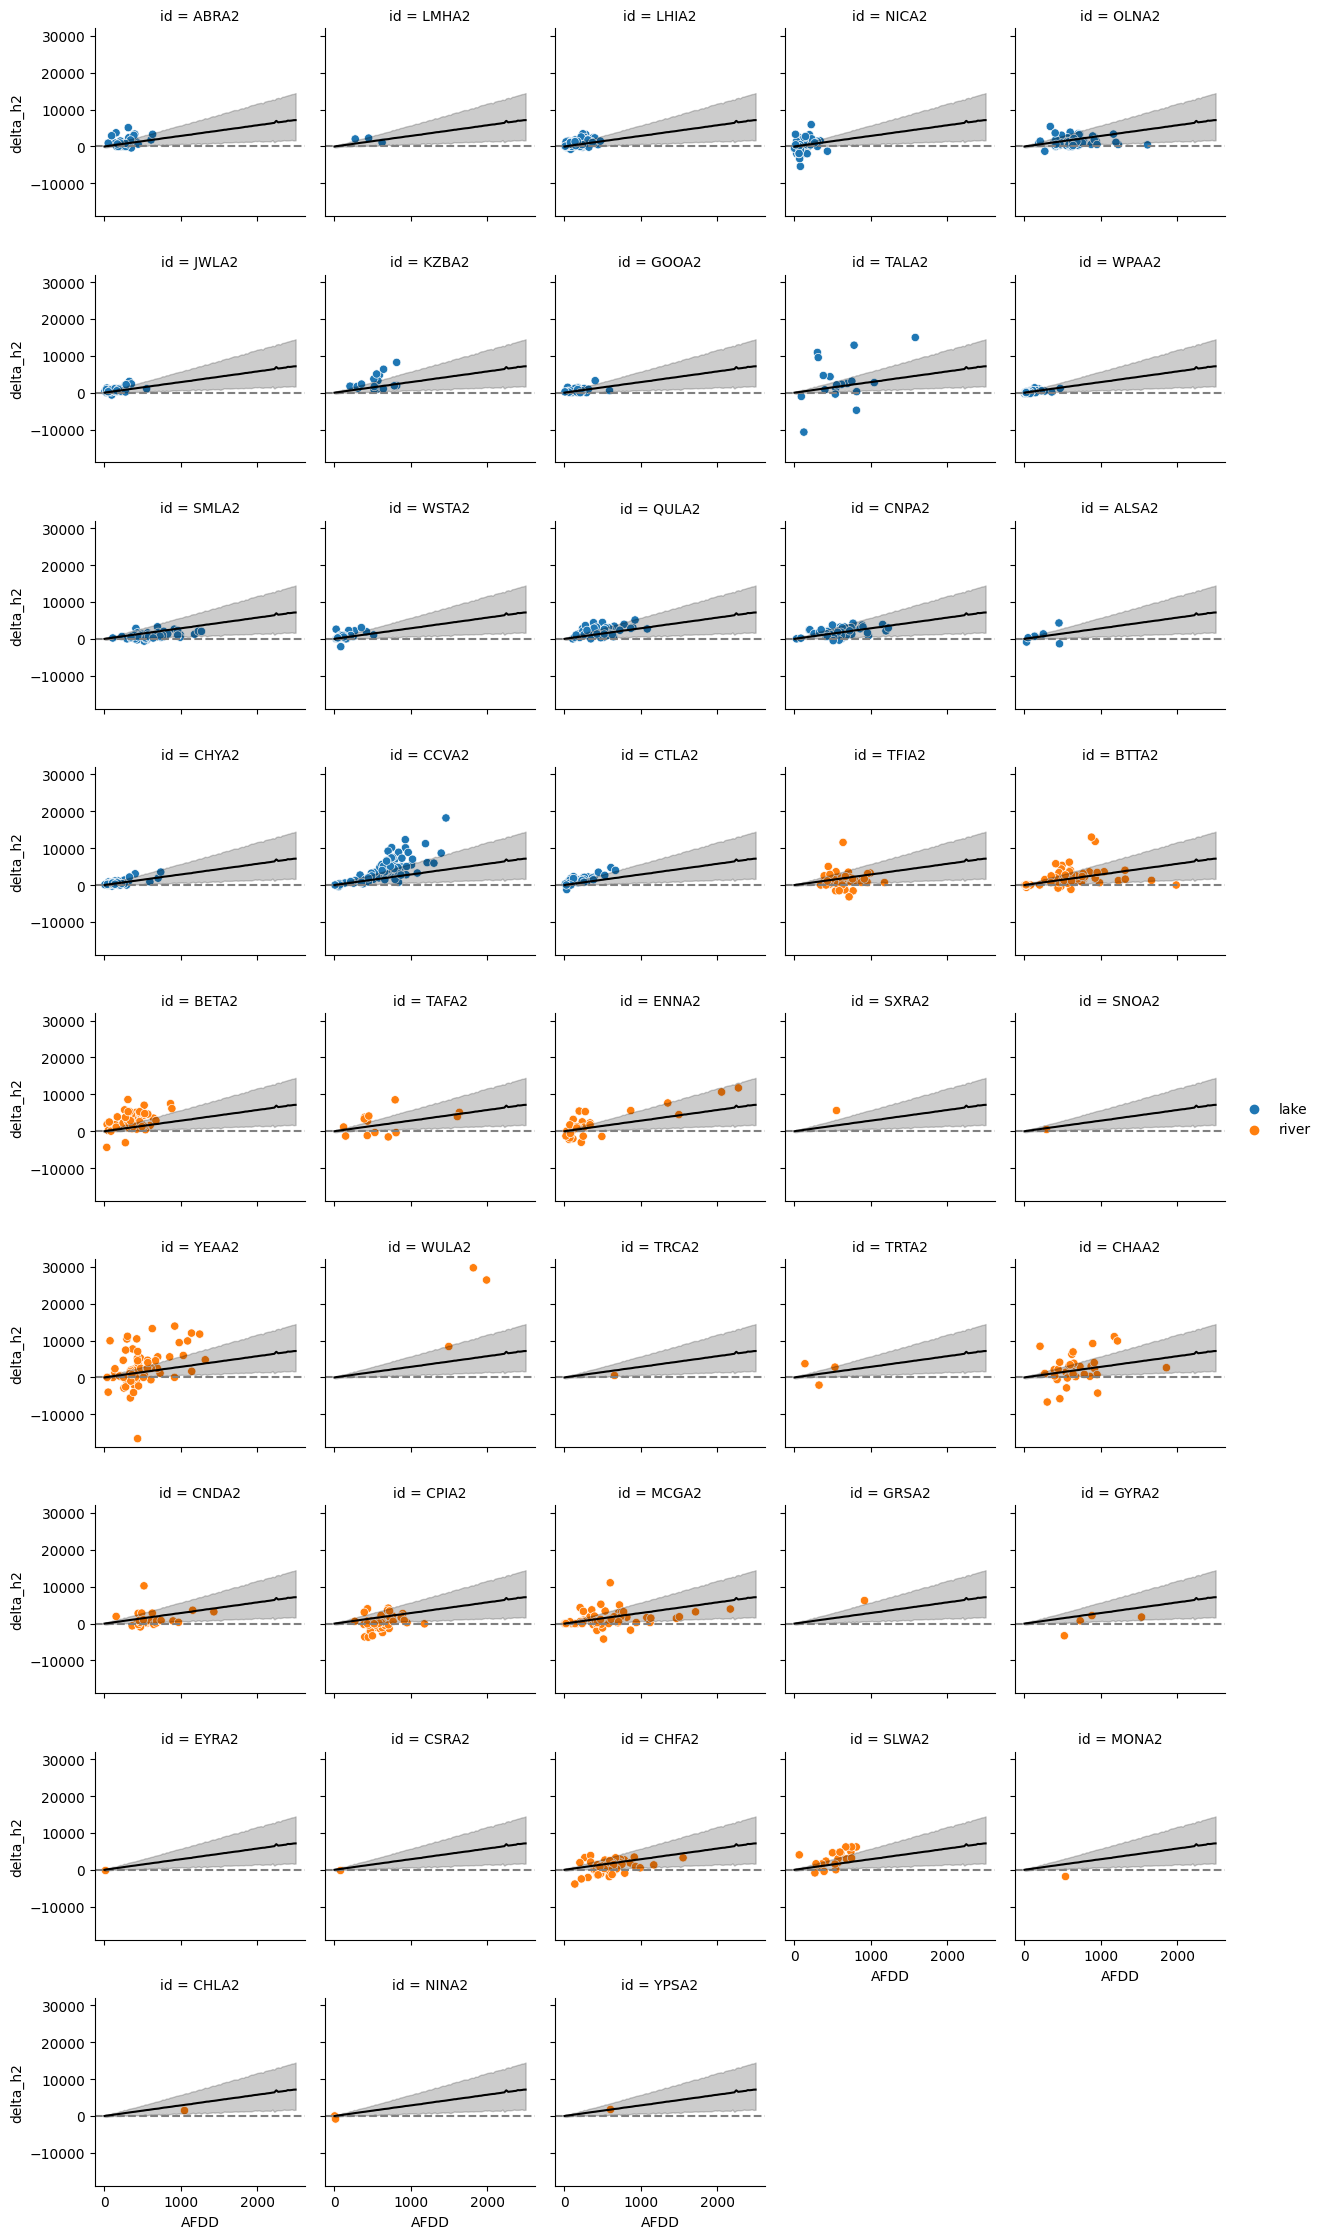

In [39]:
# base plot
g = sns.FacetGrid(
    ice_data,
    col="id",
    height=2.5,
    col_wrap=5
)
g.map_dataframe(sns.scatterplot, x="AFDD", y="delta_h2", hue="water_type", hue_order=["lake", "river"])
g.refline(y=0)
g.add_legend()


# plot prior predictions
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(unpooled, num_samples=100)

afdd = np.linspace(0, 2500, 100)

for i, ax in enumerate(g.axes.flat):
    prior_predictions = prior_predictive(
        rng_key_,
        site_id=np.array([i]).repeat(len(afdd)),
        AFDD=afdd
    )["delta_h2"]
    mean_prior_pred = prior_predictions.mean(axis=0)
    hpdi_prior_pred = hpdi(prior_predictions, 0.94)
    ax.plot(afdd, mean_prior_pred, color="black")
    ax.fill_between(afdd, hpdi_prior_pred[0], hpdi_prior_pred[1], color="black", alpha=0.2)
    
plt.show()

### Fit the Model

In [40]:
rng_key, rng_key_ = random.split(rng_key)

mcmc_unpooled = MCMC(
    NUTS(unpooled),
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
)

mcmc_unpooled.run(
    rng_key_,
    site_id=ice_data["site_idx"].values,
    AFDD=ice_data["AFDD"].values,
    delta_h2=ice_data["delta_h2"].values
)
mcmc_unpooled.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      3.65      0.63      3.63      2.66      4.72   4509.35      1.00
   beta[1]      3.18      1.27      3.04      1.16      5.18   4185.38      1.00
   beta[2]      4.02      0.46      4.00      3.19      4.71   3843.53      1.00
   beta[3]      3.12      0.80      3.14      1.80      4.42   2626.68      1.00
   beta[4]      1.60      0.17      1.60      1.30      1.86   3479.10      1.00
   beta[5]      4.18      0.86      4.17      2.68      5.52   4018.39      1.00
   beta[6]      4.82      1.21      4.90      2.79      6.65   2656.39      1.00
   beta[7]      2.41      0.74      2.38      1.14      3.60   4094.29      1.00
   beta[8]      3.05      0.48      3.04      2.34      3.92   4647.59      1.00
   beta[9]      2.18      0.65      2.16      1.10      3.19   3379.09      1.00
  beta[10]      1.34      0.15      1.34      1.10      1.59   3779.23      1.00
  beta[11]      3.87      0

### Posterior Predictive Simulation

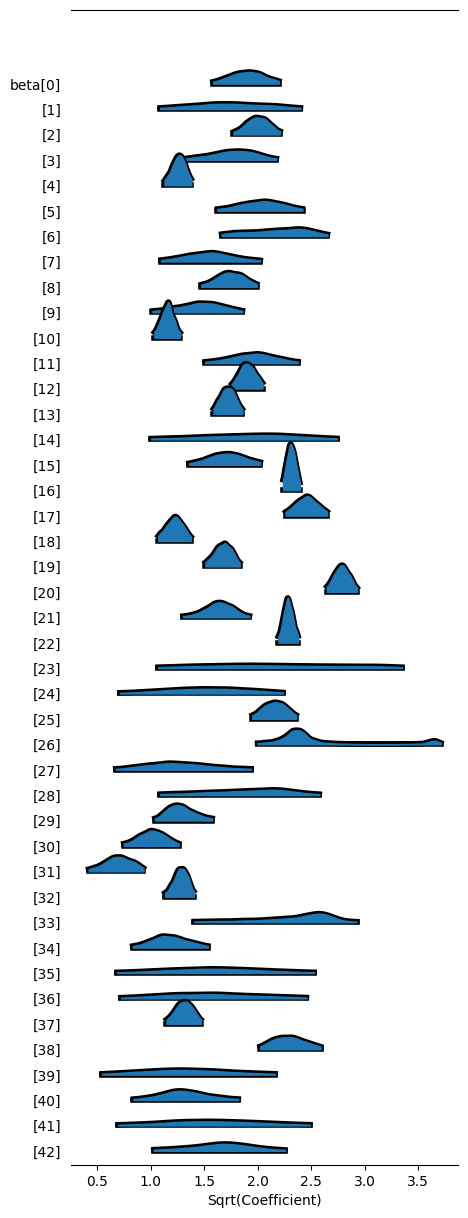

In [41]:
result_unpooled = az.from_numpyro(mcmc_unpooled)
az.plot_forest(
    result_unpooled,
    kind="ridgeplot",
    var_names=["beta"],
    transform=np.sqrt,
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(5, 15),
)
plt.xlabel("Sqrt(Coefficient)")
plt.show()

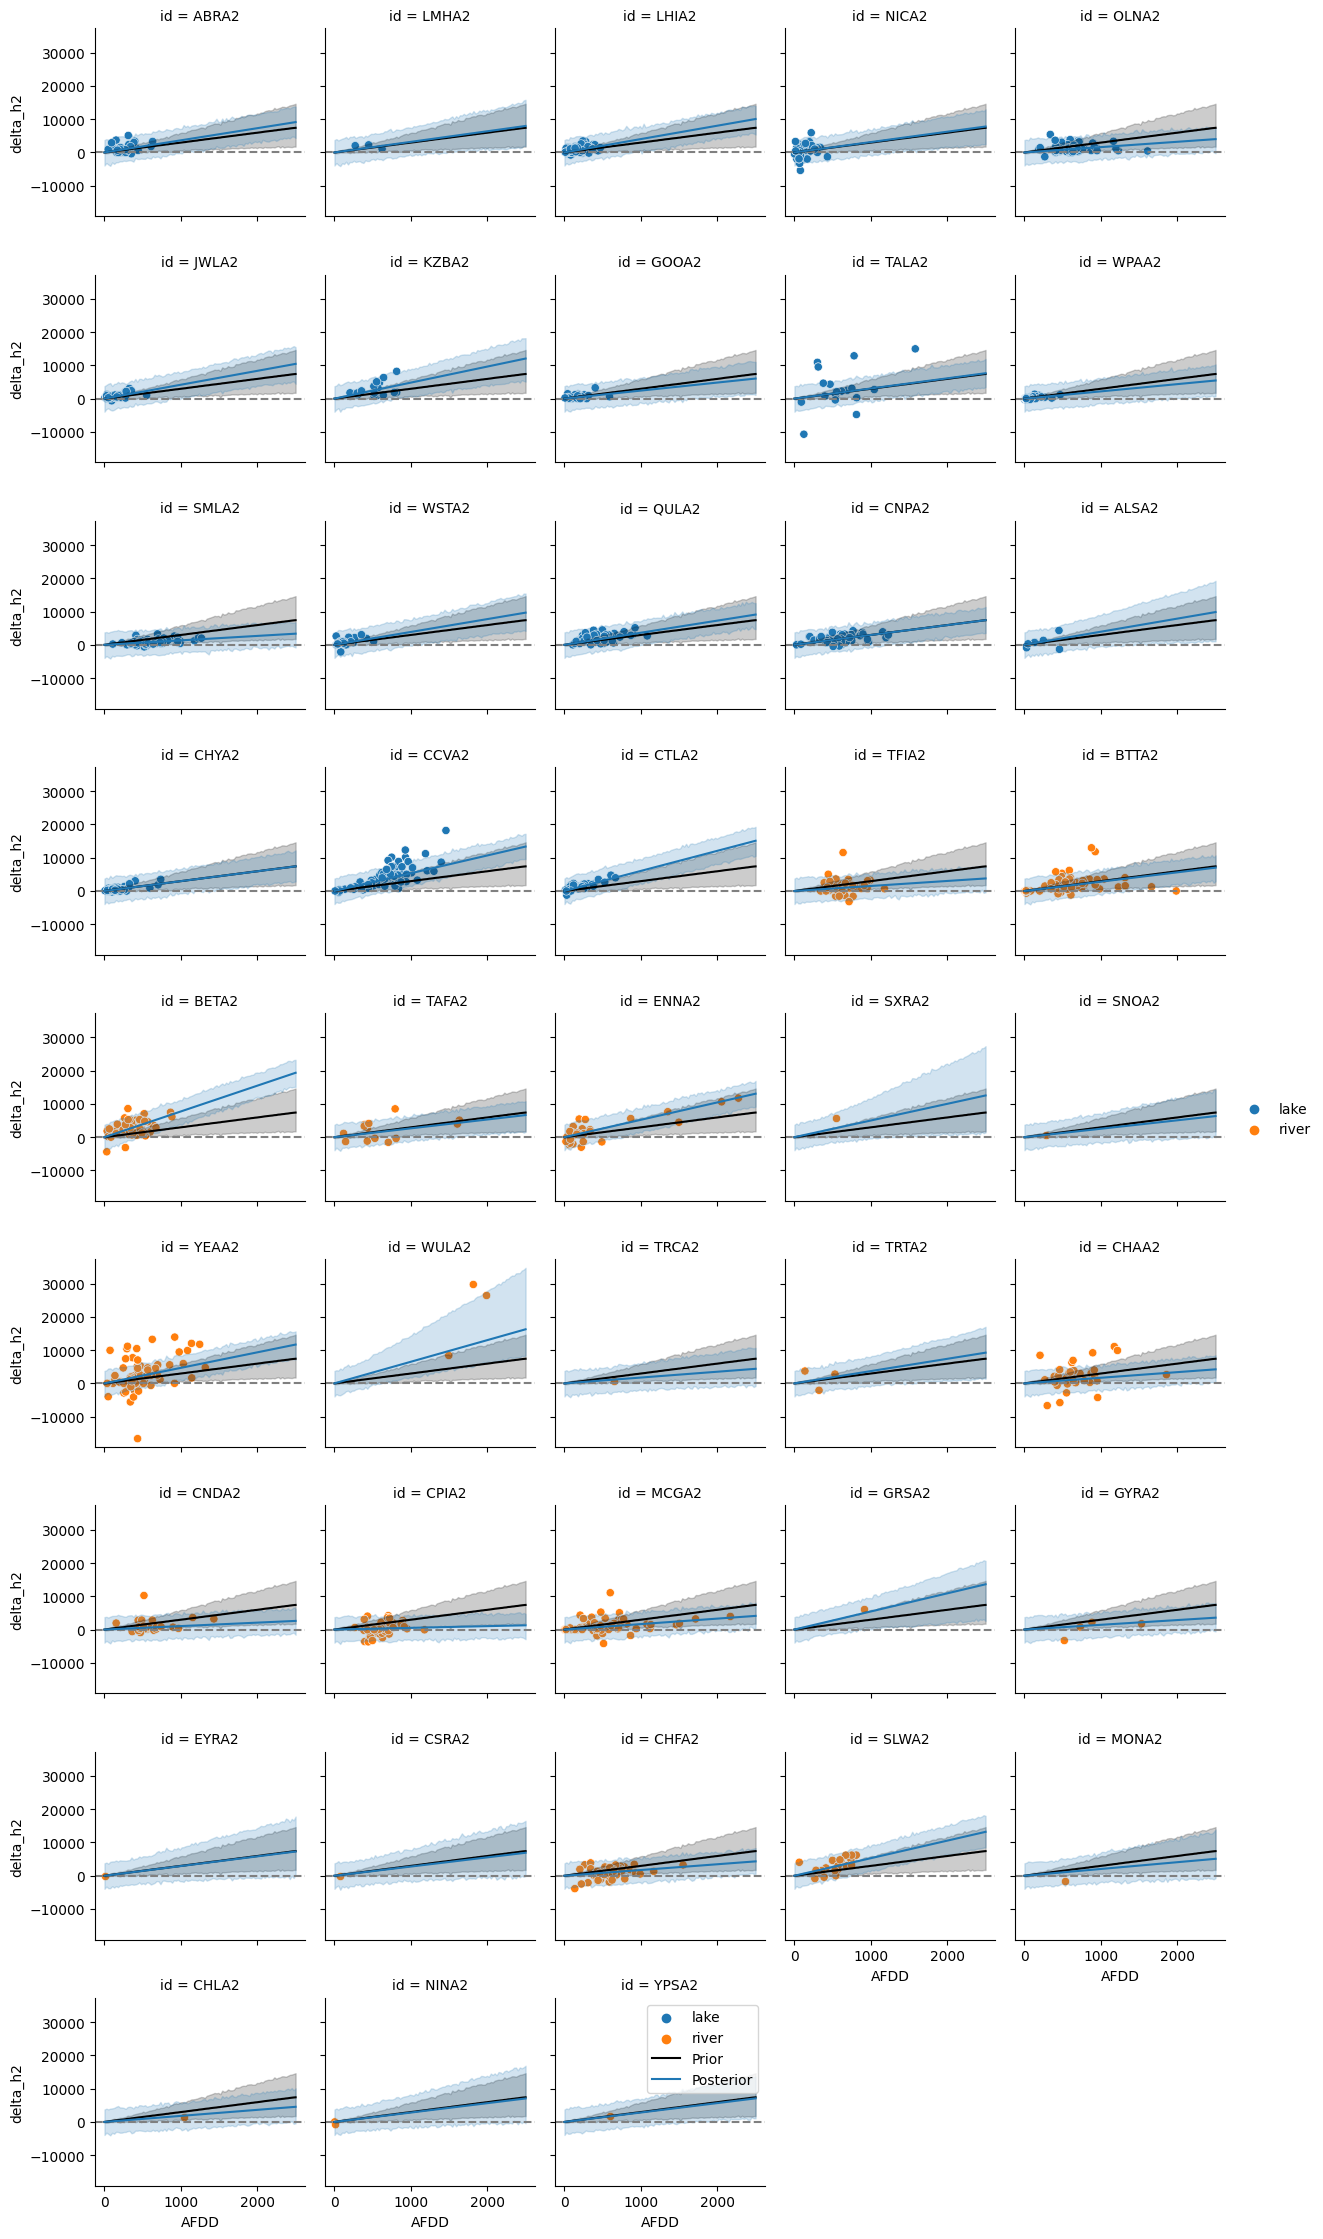

In [42]:
# base plot
g = sns.FacetGrid(
    ice_data,
    col="id",
    height=2.5,
    col_wrap=5
)
g.map_dataframe(sns.scatterplot, x="AFDD", y="delta_h2", hue="water_type", hue_order=["lake", "river"])
g.refline(y=0)
g.add_legend()


# plot posterior predictions
rng_key, rng_key_ = random.split(rng_key)

samples_unpooled = mcmc_unpooled.get_samples()
post_predictive = Predictive(unpooled, samples_unpooled)

afdd = np.linspace(0, 2500, 100)

# precalculate posterior predictions
post_predictions_unpooled = {}
mu_unpooled = {}
for i in range(len(site_map)):
    post_predictions_unpooled[i] = post_predictive(
        rng_key_,
        site_id=np.array([i]).repeat(len(afdd)),
        AFDD=afdd
    )["delta_h2"]
    mu_unpooled[i] = (jnp.expand_dims(samples_unpooled["beta"][:, i], -1)*afdd).mean(axis=0)
    
for i, ax in enumerate(g.axes.flat):
    prior_predictions = prior_predictive(
        rng_key_,
        site_id=np.array([i]).repeat(len(afdd)),
        AFDD=afdd
    )["delta_h2"]
    mean_prior_pred = prior_predictions.mean(axis=0)
    hpdi_prior_pred = hpdi(prior_predictions, 0.94)
    ax.plot(afdd, mean_prior_pred, color="black", label="Prior")
    ax.fill_between(afdd, hpdi_prior_pred[0], hpdi_prior_pred[1], color="black", alpha=0.2)
    
    hpdi_post_pred = hpdi(post_predictions_unpooled[i], 0.94)
    ax.plot(afdd, mu_unpooled[i], color="tab:blue", label="Posterior")
    ax.fill_between(afdd, hpdi_post_pred[0], hpdi_post_pred[1], color="tab:blue", alpha=0.2)
plt.legend()
plt.show()

### Compare Models

In [43]:
az.compare(
    {
        "Baseline": result_baseline_T,
        "Fully Pooled": result_fully_pooled_hs,
        "Unpooled": result_unpooled
    },
    ic="waic"
)

/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Unpooled,0,-12648.470960,71.225212,0.000000,7.123046e-01,51.127476,0.000000,True,log
Fully Pooled,1,-12810.947296,6.993359,162.476337,2.876954e-01,48.657148,30.471433,False,log
Baseline,2,-12896.712202,4.109779,248.241242,5.976990e-10,48.468558,28.522527,False,log


## Partially Pooled (Hierarchical)

Our final model is a Bayesian hierarchical model. This approach seeks to combine the advantages of both the pooled and unpooled models. Each body of water will get its own slope like the unpooled model, but the models will share information by assuming that the concentration and rates of the lake and river distributions are hyperpameters (with hyperpriors) that inform the individual lakes and rivers. There are many ways to set up this sort of model, so feel free to experiment. This is one out of three different hierarchical models I tried and got very similar results across all of them.

$$
\begin{align*}
    H &\sim \text{StudentT}(\nu, \mu, \sigma) \\
    \mu_j &\sim \beta_j \ \text{AFDD} \\
    \nu &\sim \text{Gamma}(2, 0.1) \\
    \beta_i &\sim \text{Gamma}(\text{concentration}_i, \text{rate}_i) \\
    \text{concentration}_i &\sim \text{Exponential}(1) \\
    \text{rate}_i &\sim \text{Exponential}(1) \\
    \beta_{ji} &\sim \text{Gamma}(\text{concentration}_i, \text{rate}_i) \\
    \sigma_i &\sim \text{Exponential}(0.01)
\end{align*}
$$

### Prior Predictive Simulation

In [44]:
def partial_pooled(site_id, water_type, site_to_water, AFDD, delta_h2=None):
    # top level parameters    
    concentration_lake = numpyro.sample("concentration_lake", dist.Exponential(1))
    concentration_river = numpyro.sample("concentration_river", dist.Exponential(1))
    
    concentration_water = jnp.array([concentration_lake, concentration_river])
    
    rate_lake = numpyro.sample("rate_lake", dist.Exponential(1))
    rate_river = numpyro.sample("rate_river", dist.Exponential(1))
    
    rate_water = jnp.array([rate_lake, rate_river])
    
    beta_lake = numpyro.sample("beta_lake", dist.Gamma(concentration_lake, rate_lake))
    beta_river = numpyro.sample("beta_river", dist.Gamma(concentration_river, rate_river))
    
    beta_water = jnp.array([beta_lake, beta_river])
    
    sigma_lake = numpyro.sample("sigma_lake", dist.Exponential(0.01))
    sigma_river = numpyro.sample("sigma_river", dist.Exponential(0.01))
    
    s = jnp.array([sigma_lake, sigma_river])
    
    n_sites = np.unique(site_id).shape[0]
    
    with numpyro.plate("site", n_sites):
        beta = numpyro.sample("beta", dist.Gamma(concentration_water[site_to_water], rate_water[site_to_water]))

    n_obs = site_id.shape[0]
    
    mu = numpyro.deterministic("mu", beta[site_id] * AFDD)
    sigma = numpyro.deterministic("sigma", s[water_type])
    nu = numpyro.sample("nu", dist.Gamma(2, 0.1))  # Juarez-Steel prior
    
    with numpyro.plate("data", n_obs):
        return numpyro.sample("delta_h2", dist.StudentT(nu, mu, sigma), obs=delta_h2)

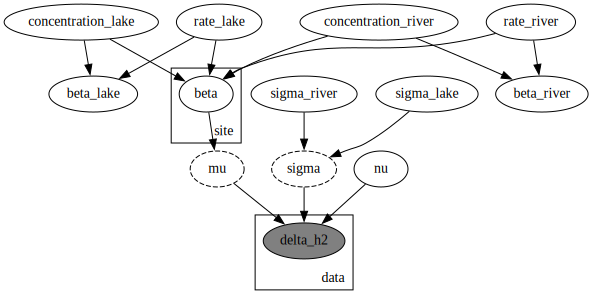

In [45]:
numpyro.render_model(
    partial_pooled,
    model_args = (ice_data["site_idx"].values, ice_data["water_type_idx"].values, ice_data[["site_idx", "water_type_idx"]].drop_duplicates().set_index("site_idx").values.ravel(), ice_data["AFDD"].values, ice_data["delta_h2"].values)
)

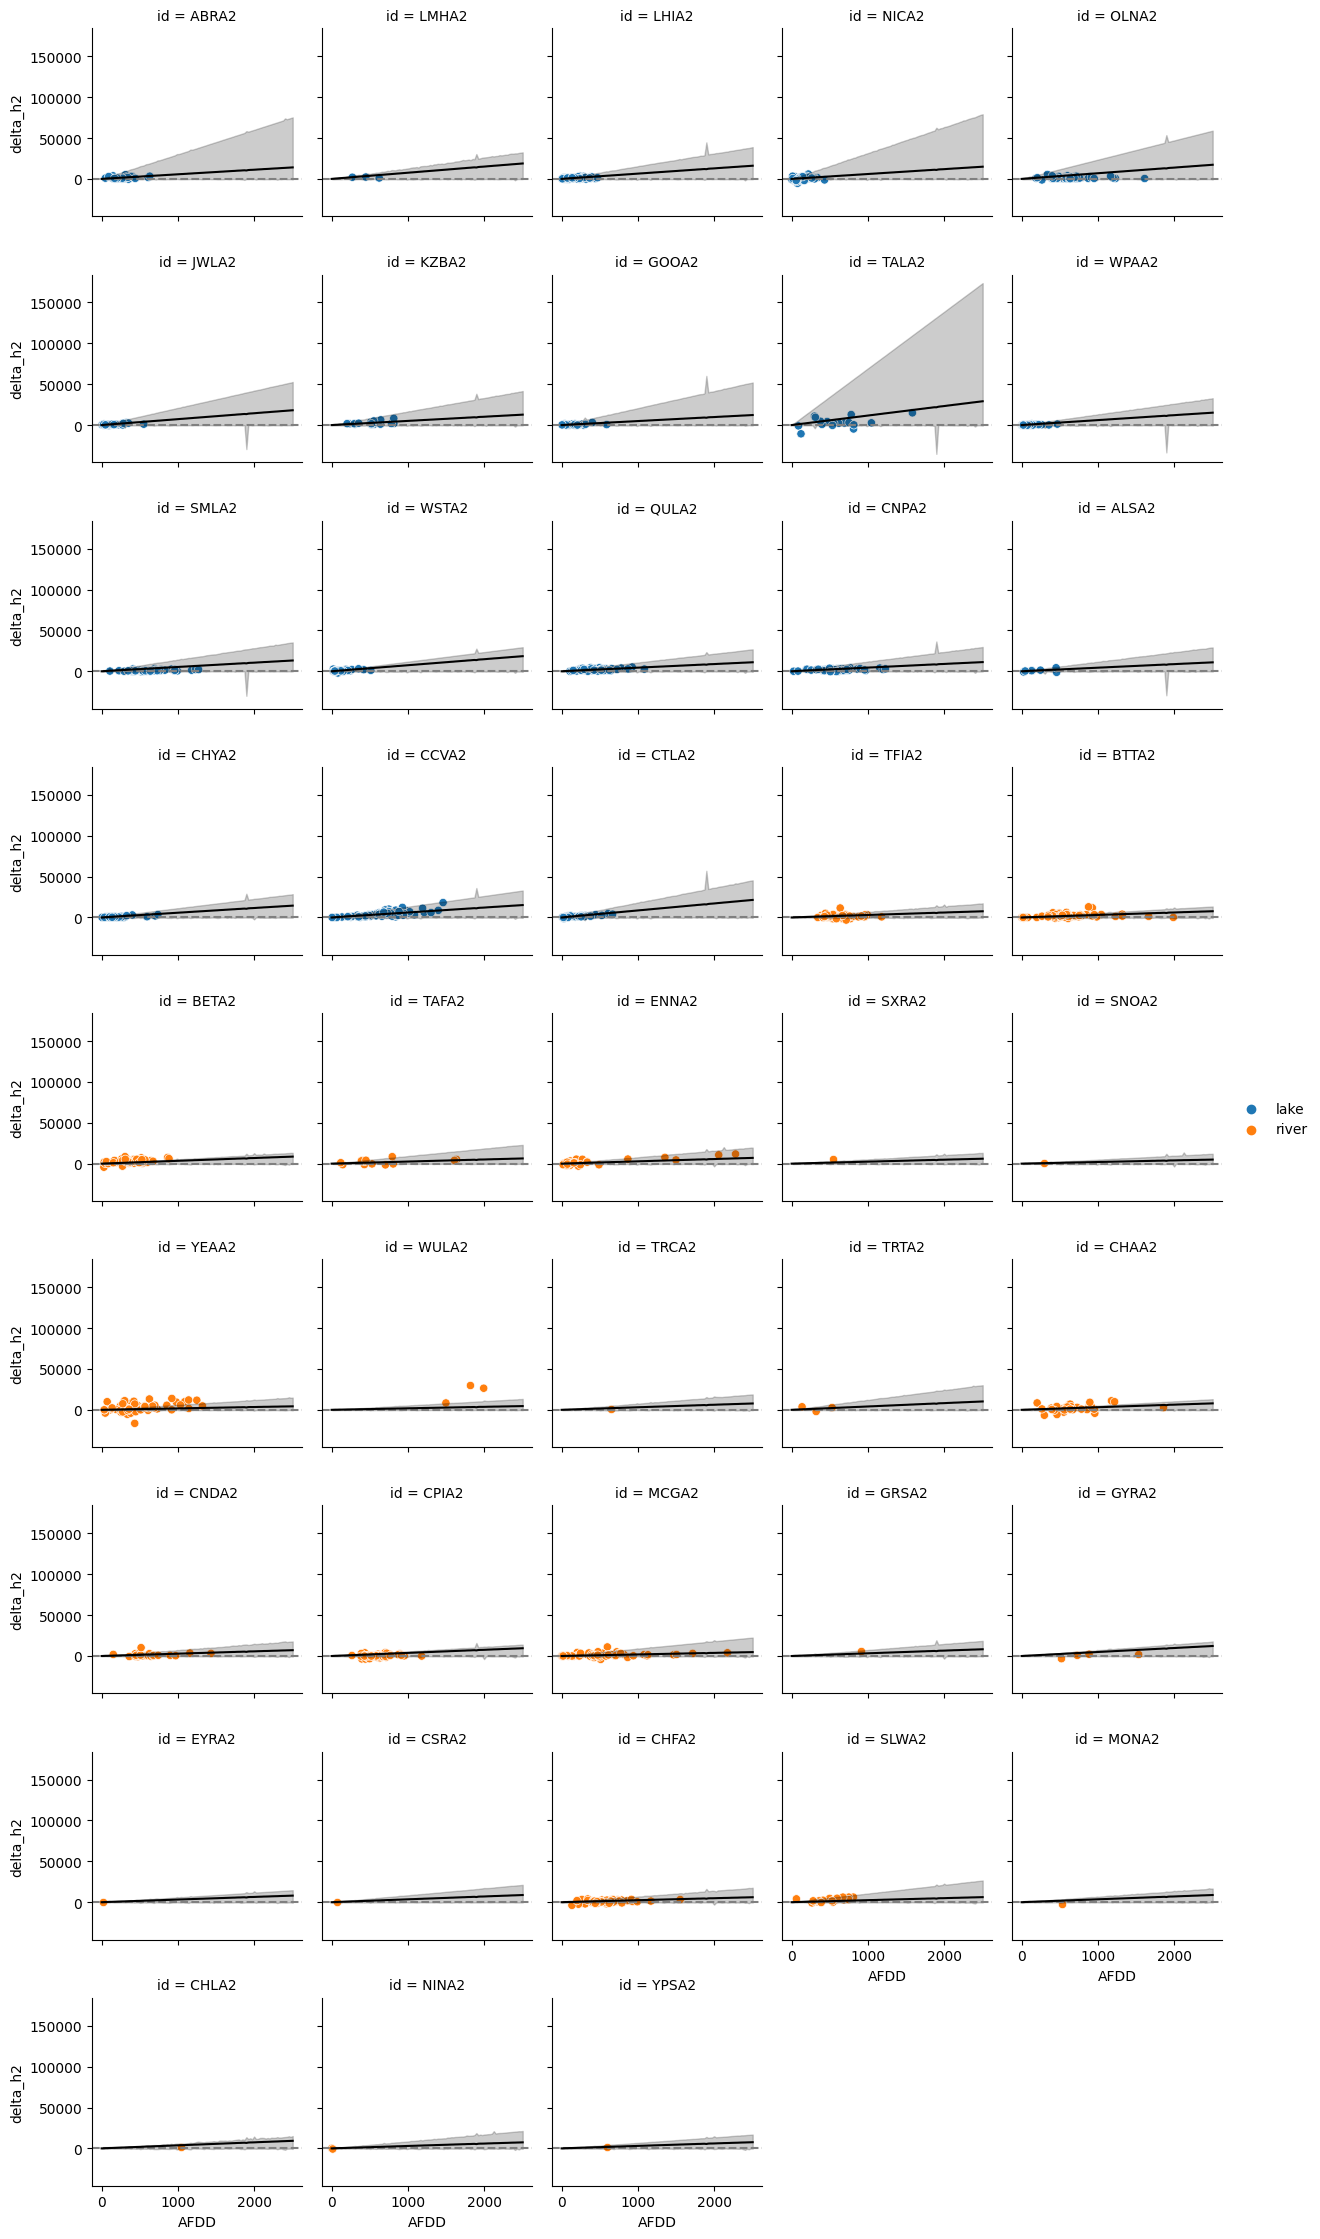

In [46]:
# base plot
g = sns.FacetGrid(
    ice_data,
    col="id",
    height=2.5,
    col_wrap=5
)
g.map_dataframe(sns.scatterplot, x="AFDD", y="delta_h2", hue="water_type", hue_order=["lake", "river"])
g.refline(y=0)
g.add_legend()


# plot prior predictions
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(partial_pooled, num_samples=100)

afdd = np.linspace(0, 2500, 100)
site_to_water = ice_data[["site_idx", "water_type_idx"]].drop_duplicates().set_index("site_idx").values.ravel()

for i, ax in enumerate(g.axes.flat):
    prior_predictions = prior_predictive(
        rng_key_,
        site_id=np.array([i]).repeat(len(afdd)),
        water_type=water_type_idx[i].repeat(len(afdd)),
        site_to_water=site_to_water,
        AFDD=afdd
    )["delta_h2"]
    mean_prior_pred = prior_predictions.mean(axis=0)
    hpdi_prior_pred = hpdi(prior_predictions, 0.94)
    ax.plot(afdd, mean_prior_pred, color="black")
    ax.fill_between(afdd, hpdi_prior_pred[0], hpdi_prior_pred[1], color="black", alpha=0.2)
    
plt.show()

### Fit the Model

In [47]:
rng_key, rng_key_ = random.split(rng_key)

mcmc_partial_pooled = MCMC(
    NUTS(partial_pooled),
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
)

mcmc_partial_pooled.run(
    rng_key_,
    site_id=ice_data["site_idx"].values,
    water_type=ice_data["water_type_idx"].values,
    site_to_water=ice_data[["site_idx", "water_type_idx"]].drop_duplicates().set_index("site_idx").values.ravel(),
    AFDD=ice_data["AFDD"].values,
    delta_h2=ice_data["delta_h2"].values
)
mcmc_partial_pooled.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
              beta[0]      3.69      0.58      3.67      2.67      4.57   4129.35      1.00
              beta[1]      3.62      1.31      3.54      1.57      5.66   3797.88      1.00
              beta[2]      4.06      0.41      4.06      3.38      4.73   5157.76      1.00
              beta[3]      3.33      0.68      3.34      2.20      4.46   3294.54      1.00
              beta[4]      1.60      0.14      1.60      1.35      1.82   5865.49      1.00
              beta[5]      4.35      0.81      4.34      3.05      5.70   4097.25      1.00
              beta[6]      5.26      1.16      5.47      3.13      6.92   1712.65      1.00
              beta[7]      2.54      0.69      2.50      1.41      3.62   4640.96      1.00
              beta[8]      3.13      0.43      3.13      2.43      3.82   3527.28      1.00
              beta[9]      2.27      0.58      2.26      1.32      3.22   3481.

### Posterior Predictive Simulation

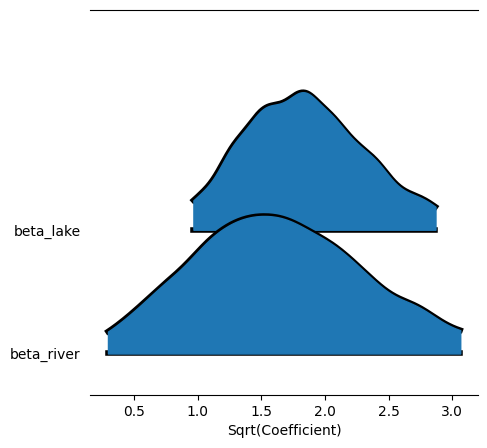

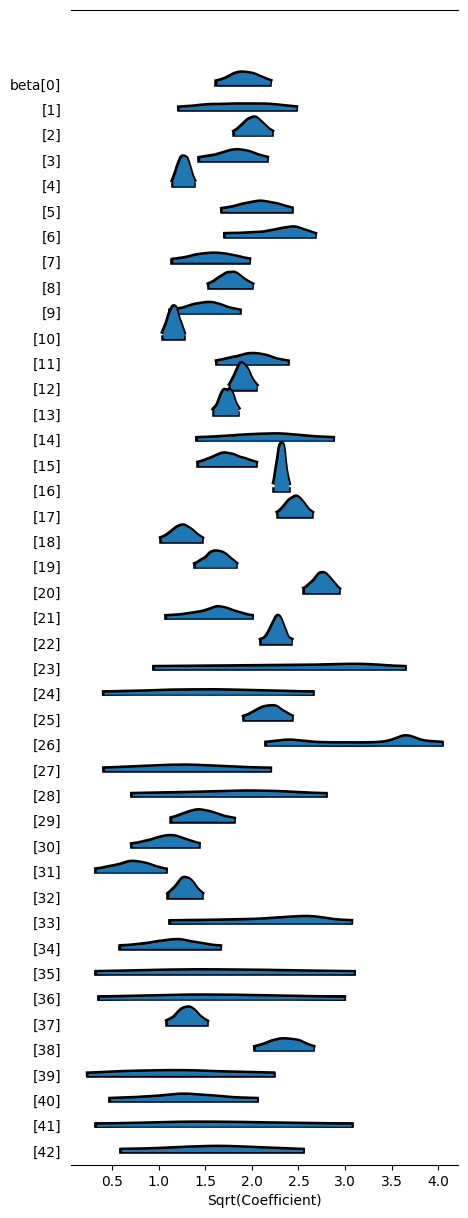

In [48]:
result_partial_pooled = az.from_numpyro(mcmc_partial_pooled)
az.plot_forest(
    result_partial_pooled,
    kind="ridgeplot",
    var_names=["beta_lake", "beta_river"],
    transform=np.sqrt,
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(5, 5),
)
plt.xlabel("Sqrt(Coefficient)")
plt.show()

az.plot_forest(
    result_partial_pooled,
    kind="ridgeplot",
    var_names=["beta"],
    transform=np.sqrt,
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(5, 15),
)
plt.xlabel("Sqrt(Coefficient)")
plt.show()

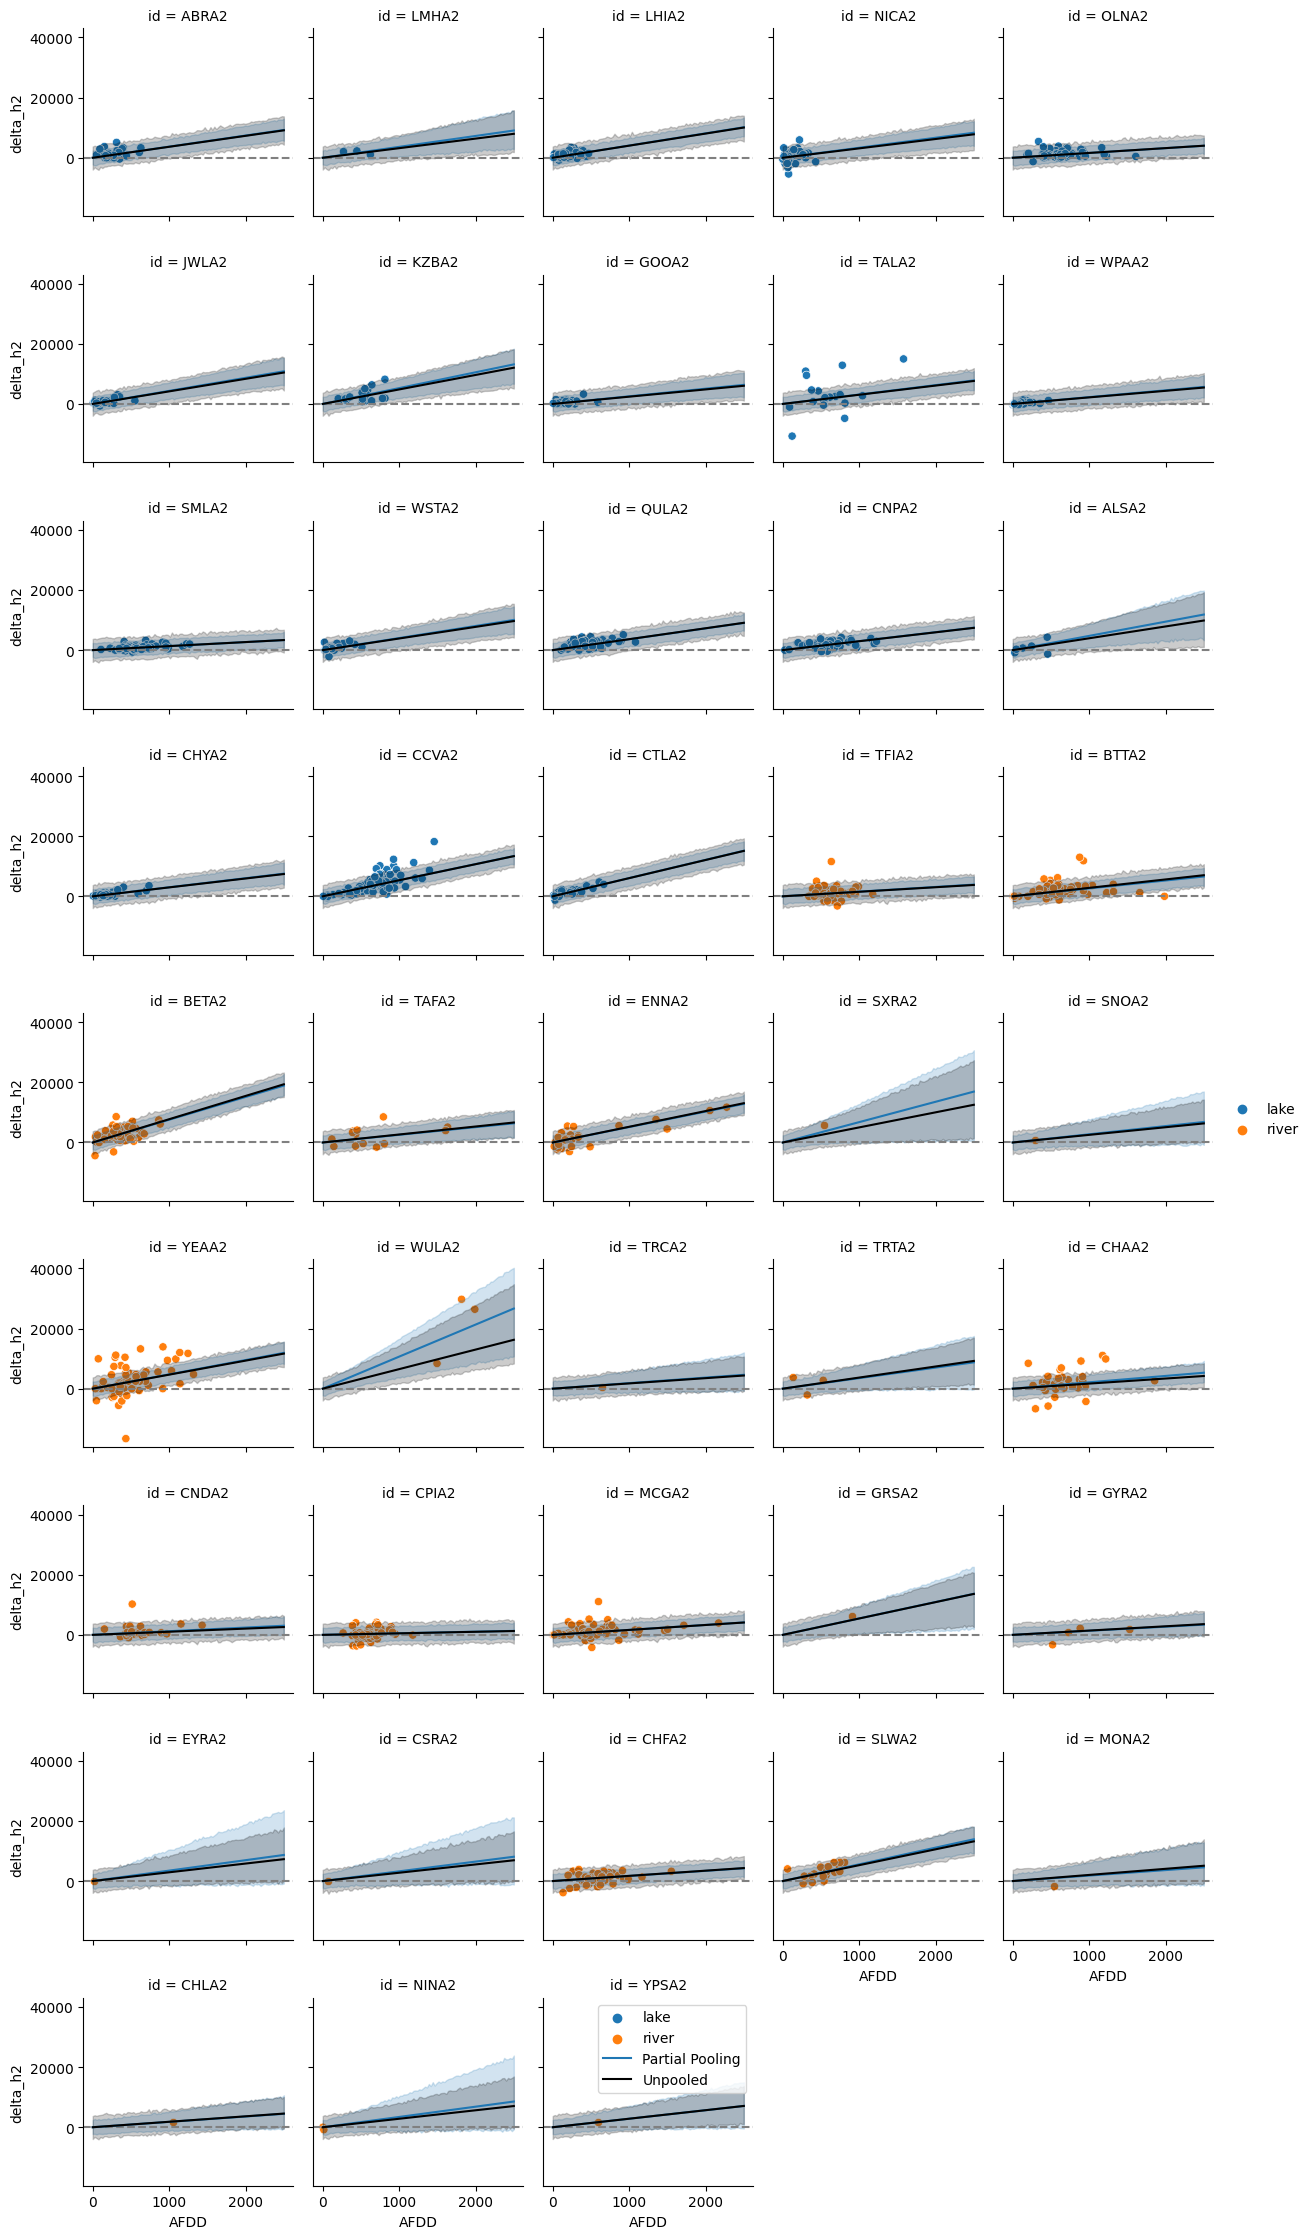

In [49]:
# base plot
g = sns.FacetGrid(
    ice_data,
    col="id",
    height=2.5,
    col_wrap=5
)
g.map_dataframe(sns.scatterplot, x="AFDD", y="delta_h2", hue="water_type", hue_order=["lake", "river"])
g.refline(y=0)
g.add_legend()


# plot posterior predictions
rng_key, rng_key_ = random.split(rng_key)

samples_partial_pooled = mcmc_partial_pooled.get_samples()
post_predictive = Predictive(partial_pooled, samples_partial_pooled)

# precalculate posterior predictions
site_to_water = ice_data[["site_idx", "water_type_idx"]].drop_duplicates().set_index("site_idx").values.ravel()
post_predictions_partial_pooled = {}
mu_partial_pooled = {}
for i in range(len(site_map)):
    post_predictions_partial_pooled[i] = post_predictive(
        rng_key_,
        site_id=np.array([i]).repeat(len(afdd)),
        water_type=water_type_idx[i].repeat(len(afdd)),
        site_to_water=site_to_water,
        AFDD=afdd
    )["delta_h2"]
    mu_partial_pooled[i] = (jnp.expand_dims(samples_partial_pooled["beta"][:, i], -1)*afdd).mean(axis=0)

for i, ax in enumerate(g.axes.flat):
    hpdi_post_pred = hpdi(post_predictions_partial_pooled[i], 0.94)
    ax.plot(afdd, mu_partial_pooled[i], color="tab:blue", label="Partial Pooling")
    ax.fill_between(afdd, hpdi_post_pred[0], hpdi_post_pred[1], color="tab:blue", alpha=0.2)
    
    hpdi_post_pred_unpooled = hpdi(post_predictions_unpooled[i], 0.94)
    ax.plot(afdd, mu_unpooled[i], color="black", label="Unpooled")
    ax.fill_between(afdd, hpdi_post_pred_unpooled[0], hpdi_post_pred_unpooled[1], color="black", alpha=0.2)
plt.legend()
plt.show()

## Compare Models

In [50]:
az.compare(
    {
        "Baseline": result_baseline_T,
        "Fully Pooled": result_fully_pooled_hs,
        "Unpooled": result_unpooled,
        "Partial Pooled": result_partial_pooled
    },
    ic="waic"
)

/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/rgnelson/anaconda3/envs/bayes/lib/pytho

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Partial Pooled,0,-12592.670388,79.466316,0.000000,7.275774e-01,50.551617,0.000000,True,log
Unpooled,1,-12648.470960,71.225212,55.800572,1.122038e-01,51.127476,12.765566,True,log
Fully Pooled,2,-12810.947296,6.993359,218.276909,1.602188e-01,48.657148,28.018094,False,log
Baseline,3,-12896.712202,4.109779,304.041814,5.228895e-11,48.468558,29.124613,False,log


In [51]:
az.compare(
    {
        "Baseline": result_baseline_T,
        "Fully Pooled": result_fully_pooled_hs,
        "Unpooled": result_unpooled,
        "Partial Pooled": result_partial_pooled
    },
    ic="loo"
)

/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rgnelson/anaconda3/envs/bayes/li

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Partial Pooled,0,-12586.803123,73.599053,0.000000,0.766429,49.861764,0.000000,True,log
Unpooled,1,-12648.609118,71.363371,61.805995,0.079080,51.191418,12.494637,True,log
Fully Pooled,2,-12810.956992,7.003054,224.153870,0.154491,48.657353,27.828437,False,log
Baseline,3,-12896.718002,4.115580,309.914880,0.000000,48.468680,29.003213,False,log


/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rgnelson/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rgnelson/anaconda3/envs/bayes/li

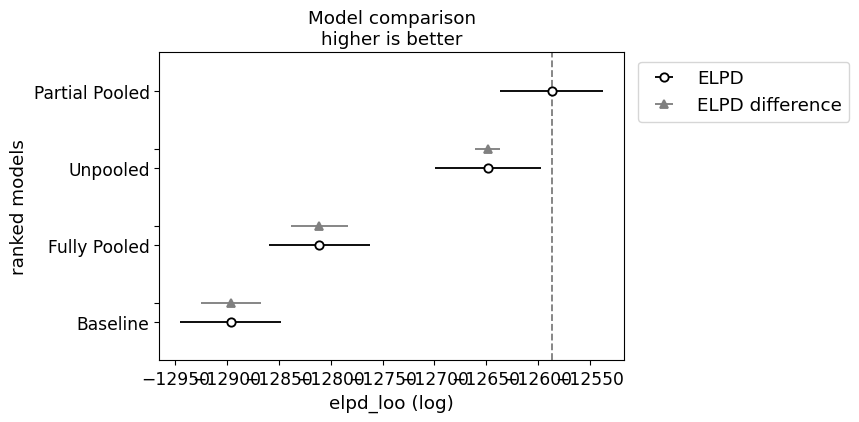

In [52]:
az.plot_compare(
    az.compare(
        {
            "Baseline": result_baseline_T,
            "Fully Pooled": result_fully_pooled_hs,
            "Unpooled": result_unpooled,
            "Partial Pooled": result_partial_pooled
        },
        ic="loo"
    )
)
plt.show()